### Imports

In [36]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

import category_encoders as ce
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

random_state = 42
np.random.seed(42)

## Additional Preprocessing for Multiclass

In [37]:
df_train = pd.read_csv('Data/df_train_preprocessed.csv')

In [38]:
#encoding for multiclass variable
mapping = {'No': 0, '<30 days': 1, '>30 days': 2}
df_train['readmitted_multiclass'] = df_train['readmitted_multiclass'].map(mapping)

#### Admission_Source

In [39]:
#Fill NA's with Unknown
df_train['admission_source'] = df_train['admission_source'].fillna("Unknown")

In [40]:
#Calculate the overall proportion for each class in 'readmitted_multiclass'
overall_proportion = df_train['readmitted_multiclass'].value_counts(normalize=True)
overall_proportion

0    0.539123
2    0.349276
1    0.111601
Name: readmitted_multiclass, dtype: float64

In [41]:
#Calculate the proportion of each class within each 'admission_source' and create columns
counts_per_admission_source = df_train.groupby(['admission_source', 'readmitted_multiclass']).size()
total_counts_per_admission_source = df_train['admission_source'].value_counts()
admission_source_proportion = counts_per_admission_source.div(total_counts_per_admission_source, level='admission_source').unstack(fill_value=0)
admission_source_proportion

readmitted_multiclass,0,1,2
admission_source,,,
Court/Law Enforcement,0.636364,0.181818,0.181818
Emergency Room,0.506982,0.116620,0.376398
Extramural Birth,1.000000,0.000000,0.000000
Not Available,0.772727,0.079545,0.147727
Physician Referral,0.569881,0.105184,0.324935
Sick Baby,1.000000,0.000000,0.000000
Transfer from Ambulatory Surgery Center,1.000000,0.000000,0.000000
Transfer from a Skilled Nursing Facility (SNF),0.589916,0.127731,0.282353
Transfer from another health care facility,0.727273,0.097311,0.175416


In [42]:
#Aggregate less common Admission Sources in one category
df_train['admission_source'] = df_train['admission_source'].apply(
    lambda x: 'Other Admission Source' 
    if x in ['HMO Referral', ' Court/Law Enforcement', 
             ' Transfer from hospital inpt/same fac reslt in a sep claim', 
             ' Transfer from critial access hospital', 
             ' Transfer from Ambulatory Surgery Center', 
             ' Extramural Birth', 'Normal Delivery', ' Sick Baby'] 
    else x
)

In [43]:
admission_source_proportion_reset = admission_source_proportion.reset_index()
df_train = df_train.merge(admission_source_proportion_reset, on='admission_source', how='left')

df_train.rename(columns={0: 'admission_source_0', 1:'admission_source_1', 2:'admission_source_2'}, inplace=True)

In [44]:
#create bins comparing the average of readmitted multiclass and the average of each class in admission source
df_train['admission_source_0_high'] = df_train['admission_source_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['admission_source_0_low'] = df_train['admission_source_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['admission_source_1_high'] = df_train['admission_source_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['admission_source_1_low'] = df_train['admission_source_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['admission_source_2_high'] = df_train['admission_source_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['admission_source_2_low'] = df_train['admission_source_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)

#### Medical_specialty

In [45]:
# Replacing missing values in 'medical_specialty' with a placeholder 'Unknown'
df_train['medical_specialty'].fillna('Unknown', inplace=True)

In [46]:
#calculate the proportion of each class within each 'medical_specialty' and create columns
counts_per_medical_specialty = df_train.groupby(['medical_specialty', 'readmitted_multiclass']).size()
total_counts_per_medical_specialty = df_train['medical_specialty'].value_counts()
medical_specialty_proportion = counts_per_medical_specialty.div(total_counts_per_medical_specialty, level='medical_specialty').unstack(fill_value=0)
medical_specialty_proportion

readmitted_multiclass,0,1,2
medical_specialty,,,
AllergyandImmunology,0.166667,0.500000,0.333333
Anesthesiology,0.800000,0.000000,0.200000
Anesthesiology-Pediatric,0.666667,0.000000,0.333333
Cardiology,0.572659,0.079386,0.347955
Cardiology-Pediatric,0.200000,0.200000,0.600000
...,...,...,...
Surgery-Thoracic,0.614458,0.096386,0.289157
Surgery-Vascular,0.498630,0.147945,0.353425
SurgicalSpecialty,0.640000,0.080000,0.280000


In [47]:
#reset the index
medical_specialty_proportion_reset = medical_specialty_proportion.reset_index()
df_train = df_train.merge(medical_specialty_proportion_reset, on='medical_specialty', how='left')

#rename the columns
df_train.rename(columns={0: 'medical_specialty_0', 1: 'medical_specialty_1', 2: 'medical_specialty_2'}, inplace=True)

In [48]:
#create bins comparing the proportion of each readmitted multiclass and the proportion of each class in medical specialty
df_train['medical_specialty_0_high'] = df_train['medical_specialty_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['medical_specialty_0_low'] = df_train['medical_specialty_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['medical_specialty_1_high'] = df_train['medical_specialty_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['medical_specialty_1_low'] = df_train['medical_specialty_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['medical_specialty_2_high'] = df_train['medical_specialty_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['medical_specialty_2_low'] = df_train['medical_specialty_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)

#### Discharge_disposition

In [49]:
df_train['discharge_disposition'] = df_train['discharge_disposition'].fillna("Unknown")

In [50]:
# Same logic as before, calculate the proportion of each class within each 'discharge_disposition' and create columns accordingly
counts_per_discharge_disposition = df_train.groupby(['discharge_disposition', 'readmitted_multiclass']).size()
total_counts_per_discharge_disposition = df_train['discharge_disposition'].value_counts()

discharge_disposition_proportion = counts_per_discharge_disposition.div(total_counts_per_discharge_disposition, level='discharge_disposition').unstack(fill_value=0)

In [51]:
discharge_disposition_proportion_reset = discharge_disposition_proportion.reset_index()

df_train = df_train.merge(discharge_disposition_proportion_reset, on='discharge_disposition', how='left')

df_train.rename(columns={0: 'discharge_disposition_0', 1: 'discharge_disposition_1', 2: 'discharge_disposition_2'}, inplace=True)

In [52]:
#create bins comparing the proportion of each readmitted multiclass and the proportion of each class in discharge disposition
df_train['discharge_disposition_0_high'] = df_train['discharge_disposition_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['discharge_disposition_0_low'] = df_train['discharge_disposition_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['discharge_disposition_1_high'] = df_train['discharge_disposition_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['discharge_disposition_1_low'] = df_train['discharge_disposition_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['discharge_disposition_2_high'] = df_train['discharge_disposition_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['discharge_disposition_2_low'] = df_train['discharge_disposition_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)

#### Diagnosis variables 

Primary Diagnosis

In [53]:
#same logic as before, calculate the proportion of each class within each 'primary diagnosis' and create columns accordingly
counts_per_primary_diagnosis = df_train.groupby(['primary_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_primary_diagnosis = df_train['primary_diagnosis'].value_counts()

primary_diagnosis_proportion = counts_per_primary_diagnosis.div(total_counts_per_primary_diagnosis, level='primary_diagnosis').unstack(fill_value=0)

In [54]:
primary_diagnosis_proportion_reset = primary_diagnosis_proportion.reset_index()

df_train = df_train.merge(primary_diagnosis_proportion_reset, on='primary_diagnosis', how='left')

df_train.rename(columns={0: 'primary_diagnosis_0', 1: 'primary_diagnosis_1', 2: 'primary_diagnosis_2'}, inplace=True)

In [55]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['primary_diagnosis_0_high'] = df_train['primary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['primary_diagnosis_0_low'] = df_train['primary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['primary_diagnosis_1_high'] = df_train['primary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['primary_diagnosis_1_low'] = df_train['primary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['primary_diagnosis_2_high'] = df_train['primary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['primary_diagnosis_2_low'] = df_train['primary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)



Secondary Diagnosis

In [56]:
# Same logic as before, calculate the proportion of each class within each 'discharge_disposition' and create columns accordingly
counts_per_secondary_diagnosis = df_train.groupby(['secondary_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_secondary_diagnosis = df_train['secondary_diagnosis'].value_counts()

secondary_diagnosis_proportion = counts_per_secondary_diagnosis.div(total_counts_per_secondary_diagnosis, level='secondary_diagnosis').unstack(fill_value=0)
secondary_diagnosis_proportion_reset = secondary_diagnosis_proportion.reset_index()

In [57]:
df_train = df_train.merge(secondary_diagnosis_proportion_reset, on='secondary_diagnosis', how='left')

df_train.rename(columns={0: 'secondary_diagnosis_0', 1: 'secondary_diagnosis_1', 2: 'secondary_diagnosis_2'}, inplace=True)

In [58]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['secondary_diagnosis_0_high'] = df_train['secondary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['secondary_diagnosis_0_low'] = df_train['secondary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['secondary_diagnosis_1_high'] = df_train['secondary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['secondary_diagnosis_1_low'] = df_train['secondary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['secondary_diagnosis_2_high'] = df_train['secondary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['secondary_diagnosis_2_low'] = df_train['secondary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)




Additional Diagnosis

In [59]:
# Same logic as before, calculate the proportion of each class within each 'additional_diagnosis' and create columns accordingly
counts_per_additional_diagnosis = df_train.groupby(['additional_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_additional_diagnosis = df_train['additional_diagnosis'].value_counts()

additional_diagnosis_proportion = counts_per_additional_diagnosis.div(total_counts_per_additional_diagnosis, level='additional_diagnosis').unstack(fill_value=0)

In [60]:
additional_diagnosis_proportion_reset = additional_diagnosis_proportion.reset_index()

df_train = df_train.merge(additional_diagnosis_proportion_reset, on='additional_diagnosis', how='left')

df_train.rename(columns={0: 'additional_diagnosis_0', 1: 'additional_diagnosis_1', 2: 'additional_diagnosis_2'}, inplace=True)

In [61]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['additional_diagnosis_0_high'] = df_train['additional_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['additional_diagnosis_0_low'] = df_train['additional_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['additional_diagnosis_1_high'] = df_train['additional_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['additional_diagnosis_1_low'] = df_train['additional_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['additional_diagnosis_2_high'] = df_train['additional_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['additional_diagnosis_2_low'] = df_train['additional_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)


## Model and feature selection

### Set train and test data

In [62]:
categorical_columns = ['race',
       'payer_code',  'admission_type',
       'medical_specialty',  'discharge_disposition',
       'admission_source', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
       'payer_code_SP', 
       'more_than_one_lab_test', 

       'admission_type_big_share', 'admission_type_big_share_Elective',
       'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',

       'medical_specialty_0_high', 'medical_specialty_0_low', 'medical_specialty_1_high', 
       'medical_specialty_1_low', 'medical_specialty_2_high', 'medical_specialty_2_low',

       'admission_source_0_high',	'admission_source_0_low',	'admission_source_1_high',	'admission_source_1_low',
       'admission_source_2_high',	'admission_source_2_low',

       'discharge_disposition_0_high', 'discharge_disposition_0_low',
       'discharge_disposition_1_high', 'discharge_disposition_1_low',
       'discharge_disposition_2_high', 'discharge_disposition_2_low',
                  
       'primary_diagnosis_2_low', 'primary_diagnosis_2_high','primary_diagnosis_1_low',
       'primary_diagnosis_1_high','primary_diagnosis_0_low','primary_diagnosis_0_high',

       'secondary_diagnosis_2_low', 'secondary_diagnosis_2_high','secondary_diagnosis_1_low',
       'secondary_diagnosis_1_high','secondary_diagnosis_0_low','secondary_diagnosis_0_high',                   
                   
       'additional_diagnosis_0_high', 'additional_diagnosis_0_low',
       'additional_diagnosis_1_high', 'additional_diagnosis_1_low',
       'additional_diagnosis_2_high', 'additional_diagnosis_2_low',
       
       'primary_diagnosis_category',
       'secondary_diagnosis_category', 'additional_diagnosis_category',
       'high_primary_diagnosis_category', 'medium_primary_diagnosis_category',
       'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',
       'medium_secondary_diagnosis_category',
       'low_secondary_diagnosis_category',
       'high_additional_diagnosis_category',
       'medium_additional_diagnosis_category',
       'low_additional_diagnosis_category', 'diabetes_diagnosis',
       'diabetes_diagnosis_4_digits', 'diabetes_type',
       'diabetes_severity_group', 'diabetes_severity_group_Mild',
       'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
       'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
       'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
       'glucose_test_performed', 'a1c_test_performed', 
       'metformin', 'rosiglitazone', 'glyburide', 'insulin', 'glipizide',
       'repaglinide', 'glimepiride', 'pioglitazone']

df_train[categorical_columns] = df_train[categorical_columns].astype('category')

In [63]:
columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 'has_weight',
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 'max_visits_of_one_type',
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 

                  'medical_specialty_0_high', 'medical_specialty_0_low', 'medical_specialty_1_high', 
                  'medical_specialty_1_low', 'medical_specialty_2_high', 'medical_specialty_2_low',

                  'admission_source_0_high',	'admission_source_0_low',	'admission_source_1_high',	'admission_source_1_low',
                  'admission_source_2_high',	'admission_source_2_low',

                  'discharge_disposition_0_high', 'discharge_disposition_0_low',
                  'discharge_disposition_1_high', 'discharge_disposition_1_low',
                  'discharge_disposition_2_high', 'discharge_disposition_2_low',
                  
                  'primary_diagnosis_2_low', 'primary_diagnosis_2_high','primary_diagnosis_1_low',
                  'primary_diagnosis_1_high','primary_diagnosis_0_low','primary_diagnosis_0_high',

                  'secondary_diagnosis_2_low', 'secondary_diagnosis_2_high','secondary_diagnosis_1_low',
                  'secondary_diagnosis_1_high','secondary_diagnosis_0_low','secondary_diagnosis_0_high',                   
                   
                  'additional_diagnosis_0_high', 'additional_diagnosis_0_low',
                  'additional_diagnosis_1_high', 'additional_diagnosis_1_low',
                  'additional_diagnosis_2_high', 'additional_diagnosis_2_low',
                                
                  'number_lab_tests',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_performed', 'glucose_test_result',
                   'a1c_test_result',
        
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 
                  
                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_No provider',
                  'payer_code_Other provider',        
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 'insulin']
                 

In [64]:
data = df_train[columns_to_use]
target = df_train['readmitted_multiclass']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### Functions for Modeling

In [65]:
def target_encoder(fit_data, transform_data, target, features_for_encoding, smoothing=100):
    target_encoder = ce.TargetEncoder(cols=features_for_encoding, smoothing=smoothing)  
    target_encoder.fit(fit_data[features_for_encoding], fit_data[target].astype(int))
    encoded_df = target_encoder.transform(transform_data[features_for_encoding])
    features_for_encoding_pass = [i + '_target' for i in features_for_encoding]
    transform_data[features_for_encoding_pass] = np.array(encoded_df)
    encoded_df = transform_data.drop(columns = features_for_encoding)
    # encoded_df =  pd.concat((transform_data[transform_data.columns.difference(features_for_encoding)],
    #                     pd.DataFrame(np.array(encoded_df), columns = features_for_encoding_pass)), axis=1)
    return encoded_df, features_for_encoding_pass

In [66]:
def scaler(fit_data, transform_data, features_for_scaling, scaling_type = 'minmax'):
    if scaling_type == 'minmax':
        sc = MinMaxScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1) 
        return scaled_df
    if scaling_type == 'standard':
        sc = StandardScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1)
        return scaled_df

In [67]:
def patient_features(df_train, df_test, multiclass = False):
    df_all = pd.concat([df_train, df_test])

    list_for_scaling = []
    
    # total visits of one patient in dataset, excluding current visit
    patient_total_visits = df_train[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_train = pd.merge(df_train, patient_total_visits, how = 'left', on = 'patient_id')
    df_train['patient_total_visits'].fillna(0, inplace = True)

    patient_total_visits = df_all[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_test = pd.merge(df_test, patient_total_visits, how = 'left', on = 'patient_id')
    df_test['patient_total_visits'].fillna(0, inplace = True)

    list_for_scaling.append('patient_total_visits')

    if multiclass == False:
        # check if we know that this person was readmitted on any other visit we know and calculate number of readmissions
        was_readmitted_encounter = df_train[['patient_id', 
                                   'encounter_id',
                                   'readmitted_binary']].groupby(['patient_id','encounter_id']).max(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_encounter'}).reset_index()
        was_readmitted_patient = df_train[['patient_id', 
                                       'readmitted_binary']].groupby(['patient_id']).sum(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_patient'}).reset_index()
        was_readmitted = pd.merge(was_readmitted_encounter, was_readmitted_patient, on = 'patient_id')
        was_readmitted['patient_num_readmitted'] = (was_readmitted['was_readmitted_patient'] - was_readmitted['was_readmitted_encounter']).astype('int')
        was_readmitted['patient_was_readmitted'] = was_readmitted['patient_num_readmitted'].apply(lambda x: 1 if x > 0 else 0).astype('category')
        df_train = pd.merge(df_train, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id')
        df_train[['patient_num_readmitted', 'patient_was_readmitted']] = df_train[['patient_num_readmitted', 'patient_was_readmitted']].fillna(0)
    
        df_test = pd.merge(df_test, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id')
        df_test[['patient_num_readmitted', 'patient_was_readmitted']] = df_test[['patient_num_readmitted', 'patient_was_readmitted']].fillna(0).astype(int)
        list_for_scaling.append('patient_num_readmitted')

    return df_train, df_test, list_for_scaling

In [68]:
def upsampler(data, 
              target,  
              upsample_type = 'simple', 
              upsample_size = 1):
    majority_class_label = data[target].value_counts().idxmax()
    minority_class_labels = data[target].value_counts().index.drop(majority_class_label)
    balanced_data = pd.DataFrame()
    if upsample_type == 'simple':
        for label in minority_class_labels:
            if len(data[data[target] == majority_class_label])*upsample_size > len(data[data[target] == label]):
                minority_upsampled = resample(data[data[target] == label], replace=True, n_samples=int(len(data[data[target] == majority_class_label])*upsample_size), 
                                                  random_state = random_state)
                balanced_data = pd.concat([balanced_data, minority_upsampled])
            else:
                balanced_data = pd.concat([balanced_data, data[data[target] == label]])
        balanced_data = pd.concat([balanced_data, data[data[target] == majority_class_label]])
    if upsample_type == 'SMOTE':
        X = data.drop(columns = target)
        categorical_features = X.select_dtypes(include='category').columns
        cat_ind = [X.columns.get_loc(col) for col in categorical_features]
        smote_nc = SMOTENC(categorical_features=cat_ind, random_state=random_state)
        X_resampled, y_resampled = smote_nc.fit_resample(X, data[target])  
        balanced_data = pd.concat([X_resampled, y_resampled], axis = 1)
    return balanced_data

In [69]:
def plot_metrics(result, params, best_models, figsize_param = (30,40)):

    fig,ax = plt.subplots(ncols = len(result[0][1]), nrows = len(params), figsize = figsize_param)
    
    for m in range(len(result[0][1])):
        for key in range(len(list(params.keys()))):
            hyperparam = list(params.keys())[key]
            metric = list(result[0][1].keys())[m]
            hyperparam_df = pd.DataFrame([(best_models[i][0][hyperparam], best_models[i][1][metric][1]) for i in range(len(best_models))], 
                                         columns = ['hyperparameter', metric]).fillna('None')
            if hyperparam_df['hyperparameter'].dtype == 'O':
                hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
            hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
            
            ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
            labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
            patch_artist=True,
            widths=0.4,         
            medianprops=dict(color='darkblue'),
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
             whiskerprops=dict(color='black'), 
             capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
                              ) 
            ax[key, m].tick_params(axis='x', labelsize=10)
            ax[key, m].set_title(hyperparam + ' - ' + metric)
    
            ax[key, m].xaxis.grid(False)
            ax[key, m].yaxis.grid(False)
    plt.tight_layout()
    
    # plt.savefig('rf_feature_selection_hyperparams.png')
    plt.show()

In [70]:
def cross_validation(data, 
                     target, 
                     model, 
                     params, 
                     multiclass,
                     
                     scaling = False,
                     features_for_scaling_minmax = [],
                     features_for_scaling_standard = [],

                     target_encoding = False,
                     features_for_encoding = [],
                     smoothing = 100,
                     
                     upsample = False, 
                     upsample_size = 1,
                     upsample_type = 'simple', 
                     cv=5
                     ):
    # Defining some lists to collect data
    feature_imp = []
    f1 = []
    confusion_matrix_list = []
    precision_score_list = []
    recall_score_list = []
    roc_auc_score_list = []

    # A bit of resampling just to mix data
    data = data.sample(frac=1, random_state=random_state)
    data[target] = data[target].astype(int)
    

    # create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
    split = list(skf.split(data.drop(columns = target), data[target]))
    all_train_index = [i[0] for i in split]
    all_val_index = [i[1] for i in split]
    
    for i in tqdm(range(cv)):
        val_index = all_val_index[i]
        train_index = all_train_index[i]
        train_data, val_data = data.loc[train_index], data.loc[val_index]

        #Target encoding
        if target_encoding == True:
                val_data = target_encoder(train_data, val_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)[0]
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax

        #creating features on patient level that we will use
        train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale
 
        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
                
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)

        # Defining train and val datasets
        X_train = train_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_train = train_data[target]
        
        X_val = val_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_val = val_data[target]


        # Fit and predict
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        # Get probability predictions
        y_pred_train_proba = model.predict_proba(X_train)
        y_pred_val_proba = model.predict_proba(X_val)

        #Feature importances if our model can do this
        try:
            try:
                feature_imp.append(model.feature_importances_)
            except:
                pass
            try:
                feature_imp.append(model.coef_)
            except:
                pass
        except:
            pass

        # Calculating f1 scores and other metrics
        if multiclass == False:
            f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
            recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
            precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
        if multiclass == True:
            f1.append([f1_score( y_train, y_pred_train, average = 'weighted'), f1_score(y_val, y_pred_val, average = 'weighted')])
            recall_score_list.append([recall_score( y_train, y_pred_train, average = 'weighted'), recall_score(y_val, y_pred_val, average = 'weighted')])
            precision_score_list.append([precision_score(y_train, y_pred_train, average = 'weighted'), precision_score(y_val, y_pred_val, average = 'weighted')])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train_proba, multi_class='ovr', average = 'weighted'), roc_auc_score(y_val, y_pred_val_proba, multi_class='ovr', average = 'weighted')])

        
        confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])

    # Printing results
    print(model)
    print('F1 train: {:.3f}, F1_val: {:.3f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    return [model.get_params(), 
            {'f1' : np.array(f1).mean(axis = 0), 
             'recall_score' : np.array(recall_score_list).mean(axis = 0),
             'precision_score' : np.array(precision_score_list).mean(axis = 0),
             'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
            }, 
            {'f1' : f1, 
             'recall_score' : recall_score_list,
             'precision_score' : precision_score_list,
             'roc_auc_score' : roc_auc_score_list,
             'confusion_matrix': confusion_matrix_list
            },
            X_train.columns, 
            np.median(np.array(feature_imp), axis = 0),
            ]

In [71]:
features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result']
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

data = pd.concat([X_train, y_train], axis = 1)
data.reset_index(inplace = True)

target = 'readmitted_multiclass'

### Feature selection

#### Random Forest MDI

In [356]:
'''model = RandomForestClassifier(random_state = random_state)
params = {
    'n_estimators': np.arange(50, 300, 20),
    'max_depth': np.arange(6, 30, 2),
    'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.1,0.7,0.1)
}

result = []
for i in tqdm(range(50)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params,
                     multiclass = True,      
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,    
                     upsample = False,   
                     cv=5))'''

  2%|▏         | 1/50 [03:45<3:04:09, 225.51s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=290, random_state=42)
F1 train: 0.678, F1_val: 0.622


  4%|▍         | 2/50 [05:38<2:07:28, 159.34s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.1, min_samples_leaf=1e-06,
                       min_samples_split=0.000201, n_estimators=250,
                       random_state=42)
F1 train: 0.911, F1_val: 0.642


  6%|▌         | 3/50 [07:41<1:51:44, 142.64s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.2, min_samples_leaf=0.001201,
                       min_samples_split=0.000101, n_estimators=290,
                       random_state=42)
F1 train: 0.635, F1_val: 0.607


  8%|▊         | 4/50 [09:53<1:46:18, 138.66s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.2, min_samples_leaf=1e-06,
                       min_samples_split=1e-06, n_estimators=190,
                       random_state=42)
F1 train: 0.964, F1_val: 0.641


 10%|█         | 5/50 [13:18<2:01:56, 162.58s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=1e-06, n_estimators=270,
                       random_state=42)
F1 train: 0.661, F1_val: 0.616


 12%|█▏        | 6/50 [14:48<1:41:09, 137.94s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=22, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=150, random_state=42)
F1 train: 0.781, F1_val: 0.640


 14%|█▍        | 7/50 [15:42<1:19:03, 110.32s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.6, min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.0009010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.677, F1_val: 0.618


 16%|█▌        | 8/50 [15:57<56:03, 80.08s/it]   

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=20, max_features=0.1,
                       min_samples_leaf=0.001201, min_samples_split=0.000701,
                       n_estimators=50, random_state=42)
F1 train: 0.617, F1_val: 0.593


 18%|█▊        | 9/50 [16:25<43:30, 63.66s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.701, F1_val: 0.625


 20%|██        | 10/50 [21:02<1:26:24, 129.62s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=22, max_features=0.4,
                       min_samples_leaf=0.000201, min_samples_split=0.000201,
                       n_estimators=290, random_state=42)
F1 train: 0.813, F1_val: 0.643


 22%|██▏       | 11/50 [24:07<1:35:13, 146.50s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18, max_features=0.2,
                       min_samples_leaf=1e-06, min_samples_split=1e-06,
                       n_estimators=290, random_state=42)
F1 train: 0.962, F1_val: 0.641


 24%|██▍       | 12/50 [25:37<1:21:58, 129.44s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.001801,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.620, F1_val: 0.601


 26%|██▌       | 13/50 [28:02<1:22:41, 134.09s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.001001, min_samples_split=0.000501,
                       n_estimators=270, random_state=42)
F1 train: 0.651, F1_val: 0.613


 28%|██▊       | 14/50 [29:30<1:11:59, 120.00s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26, max_features=0.5,
                       min_samples_leaf=0.001201, min_samples_split=0.000501,
                       n_estimators=110, random_state=42)
F1 train: 0.648, F1_val: 0.611


 30%|███       | 15/50 [31:43<1:12:23, 124.09s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.30000000000000004,
                       min_samples_leaf=0.001801, min_samples_split=0.000701,
                       n_estimators=270, random_state=42)
F1 train: 0.617, F1_val: 0.599


 32%|███▏      | 16/50 [32:51<1:00:42, 107.12s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features=0.30000000000000004, min_samples_leaf=1e-06,
                       min_samples_split=0.000701, n_estimators=90,
                       random_state=42)
F1 train: 0.815, F1_val: 0.643


 34%|███▍      | 17/50 [34:15<55:04, 100.15s/it]  

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       max_features=0.5, min_samples_leaf=1e-06,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.621, F1_val: 0.605


 36%|███▌      | 18/50 [35:35<50:14, 94.19s/it] 

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=6, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=290, random_state=42)
F1 train: 0.584, F1_val: 0.584


 38%|███▊      | 19/50 [38:04<57:05, 110.50s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18, max_features=0.4,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=1e-06, n_estimators=210,
                       random_state=42)
F1 train: 0.671, F1_val: 0.618


 40%|████      | 20/50 [39:27<51:07, 102.27s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=0.2,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=210, random_state=42)
F1 train: 0.645, F1_val: 0.610


 42%|████▏     | 21/50 [41:57<56:25, 116.73s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.6,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=110, random_state=42)
F1 train: 0.829, F1_val: 0.643


 44%|████▍     | 22/50 [42:34<43:15, 92.70s/it] 

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.6,
                       min_samples_leaf=1e-06,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=50, random_state=42)
F1 train: 0.625, F1_val: 0.606


 46%|████▌     | 23/50 [44:24<44:08, 98.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=190, random_state=42)
F1 train: 0.660, F1_val: 0.617


 48%|████▊     | 24/50 [45:11<35:46, 82.54s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=22, max_features=0.1,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=150, random_state=42)
F1 train: 0.639, F1_val: 0.605


 50%|█████     | 25/50 [46:04<30:44, 73.80s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26, max_features=0.5,
                       min_samples_leaf=0.001601, min_samples_split=0.000701,
                       n_estimators=70, random_state=42)
F1 train: 0.632, F1_val: 0.605


 52%|█████▏    | 26/50 [46:39<24:51, 62.15s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=0.1,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.720, F1_val: 0.627


 54%|█████▍    | 27/50 [48:55<32:15, 84.17s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=18, max_features=0.6,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=110, random_state=42)
F1 train: 0.732, F1_val: 0.630


 56%|█████▌    | 28/50 [51:37<39:24, 107.49s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18, max_features=0.5,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=190, random_state=42)
F1 train: 0.676, F1_val: 0.619


 58%|█████▊    | 29/50 [55:40<51:54, 148.29s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.5,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=270,
                       random_state=42)
F1 train: 0.682, F1_val: 0.622


 60%|██████    | 30/50 [57:11<43:41, 131.05s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4, min_samples_leaf=0.000201,
                       min_samples_split=0.000501, n_estimators=110,
                       random_state=42)
F1 train: 0.748, F1_val: 0.637


 62%|██████▏   | 31/50 [59:50<44:12, 139.62s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.6,
                       min_samples_leaf=0.001401, min_samples_split=0.000201,
                       n_estimators=170, random_state=42)
F1 train: 0.630, F1_val: 0.605


 64%|██████▍   | 32/50 [1:00:48<34:30, 115.03s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.4,
                       min_samples_leaf=1e-06, min_samples_split=1e-06,
                       n_estimators=50, random_state=42)
F1 train: 0.986, F1_val: 0.637


 66%|██████▌   | 33/50 [1:03:10<34:52, 123.11s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000201,
                       n_estimators=270, random_state=42)
F1 train: 0.785, F1_val: 0.640


 68%|██████▊   | 34/50 [1:04:15<28:09, 105.59s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=90, random_state=42)
F1 train: 0.637, F1_val: 0.606


 70%|███████   | 35/50 [1:07:29<33:01, 132.08s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.6, min_samples_leaf=0.001601,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=210, random_state=42)
F1 train: 0.635, F1_val: 0.607


 72%|███████▏  | 36/50 [1:11:29<38:24, 164.60s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.6, min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=230, random_state=42)
F1 train: 0.680, F1_val: 0.620


 74%|███████▍  | 37/50 [1:11:58<26:49, 123.81s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18, max_features=0.2,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=70, random_state=42)
F1 train: 0.633, F1_val: 0.606


 76%|███████▌  | 38/50 [1:12:20<18:39, 93.29s/it] 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.2, min_samples_leaf=0.001201,
                       min_samples_split=0.0009010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.633, F1_val: 0.605


 78%|███████▊  | 39/50 [1:14:10<18:01, 98.31s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=210, random_state=42)
F1 train: 0.577, F1_val: 0.578


 80%|████████  | 40/50 [1:17:45<22:12, 133.26s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, n_estimators=290,
                       random_state=42)
F1 train: 0.695, F1_val: 0.624


 82%|████████▏ | 41/50 [1:19:17<18:07, 120.82s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=14, max_features=0.5,
                       min_samples_leaf=0.001401, min_samples_split=1e-06,
                       n_estimators=110, random_state=42)
F1 train: 0.632, F1_val: 0.603


 84%|████████▍ | 42/50 [1:21:13<15:55, 119.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=8, max_features=0.4, min_samples_leaf=0.001001,
                       min_samples_split=0.000101, n_estimators=210,
                       random_state=42)
F1 train: 0.609, F1_val: 0.598


 86%|████████▌ | 43/50 [1:22:39<12:46, 109.54s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=8, max_features=0.6, min_samples_leaf=0.000201,
                       min_samples_split=1e-06, n_estimators=110,
                       random_state=42)
F1 train: 0.616, F1_val: 0.600


 88%|████████▊ | 44/50 [1:24:46<11:29, 114.84s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=22, max_features=0.6,
                       min_samples_leaf=0.001401, min_samples_split=0.000101,
                       n_estimators=130, random_state=42)
F1 train: 0.633, F1_val: 0.603


 90%|█████████ | 45/50 [1:26:58<09:59, 119.86s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000701, n_estimators=230,
                       random_state=42)
F1 train: 0.649, F1_val: 0.614


 92%|█████████▏| 46/50 [1:30:51<10:14, 153.74s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.5, min_samples_leaf=0.001401,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=290, random_state=42)
F1 train: 0.640, F1_val: 0.609


 94%|█████████▍| 47/50 [1:33:36<07:51, 157.17s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=8, max_features=0.5, min_samples_leaf=0.001401,
                       min_samples_split=1e-06, n_estimators=270,
                       random_state=42)
F1 train: 0.604, F1_val: 0.595


 96%|█████████▌| 48/50 [1:35:30<04:48, 144.14s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000501, n_estimators=290,
                       random_state=42)
F1 train: 0.643, F1_val: 0.610


 98%|█████████▊| 49/50 [1:35:55<01:48, 108.57s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=8, max_features=0.1, min_samples_leaf=0.001601,
                       min_samples_split=0.000101, n_estimators=110,
                       random_state=42)
F1 train: 0.593, F1_val: 0.589


100%|██████████| 50/50 [1:36:40<00:00, 116.01s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.1,
                       min_samples_leaf=0.001401, min_samples_split=0.000701,
                       n_estimators=190, random_state=42)
F1 train: 0.615, F1_val: 0.595


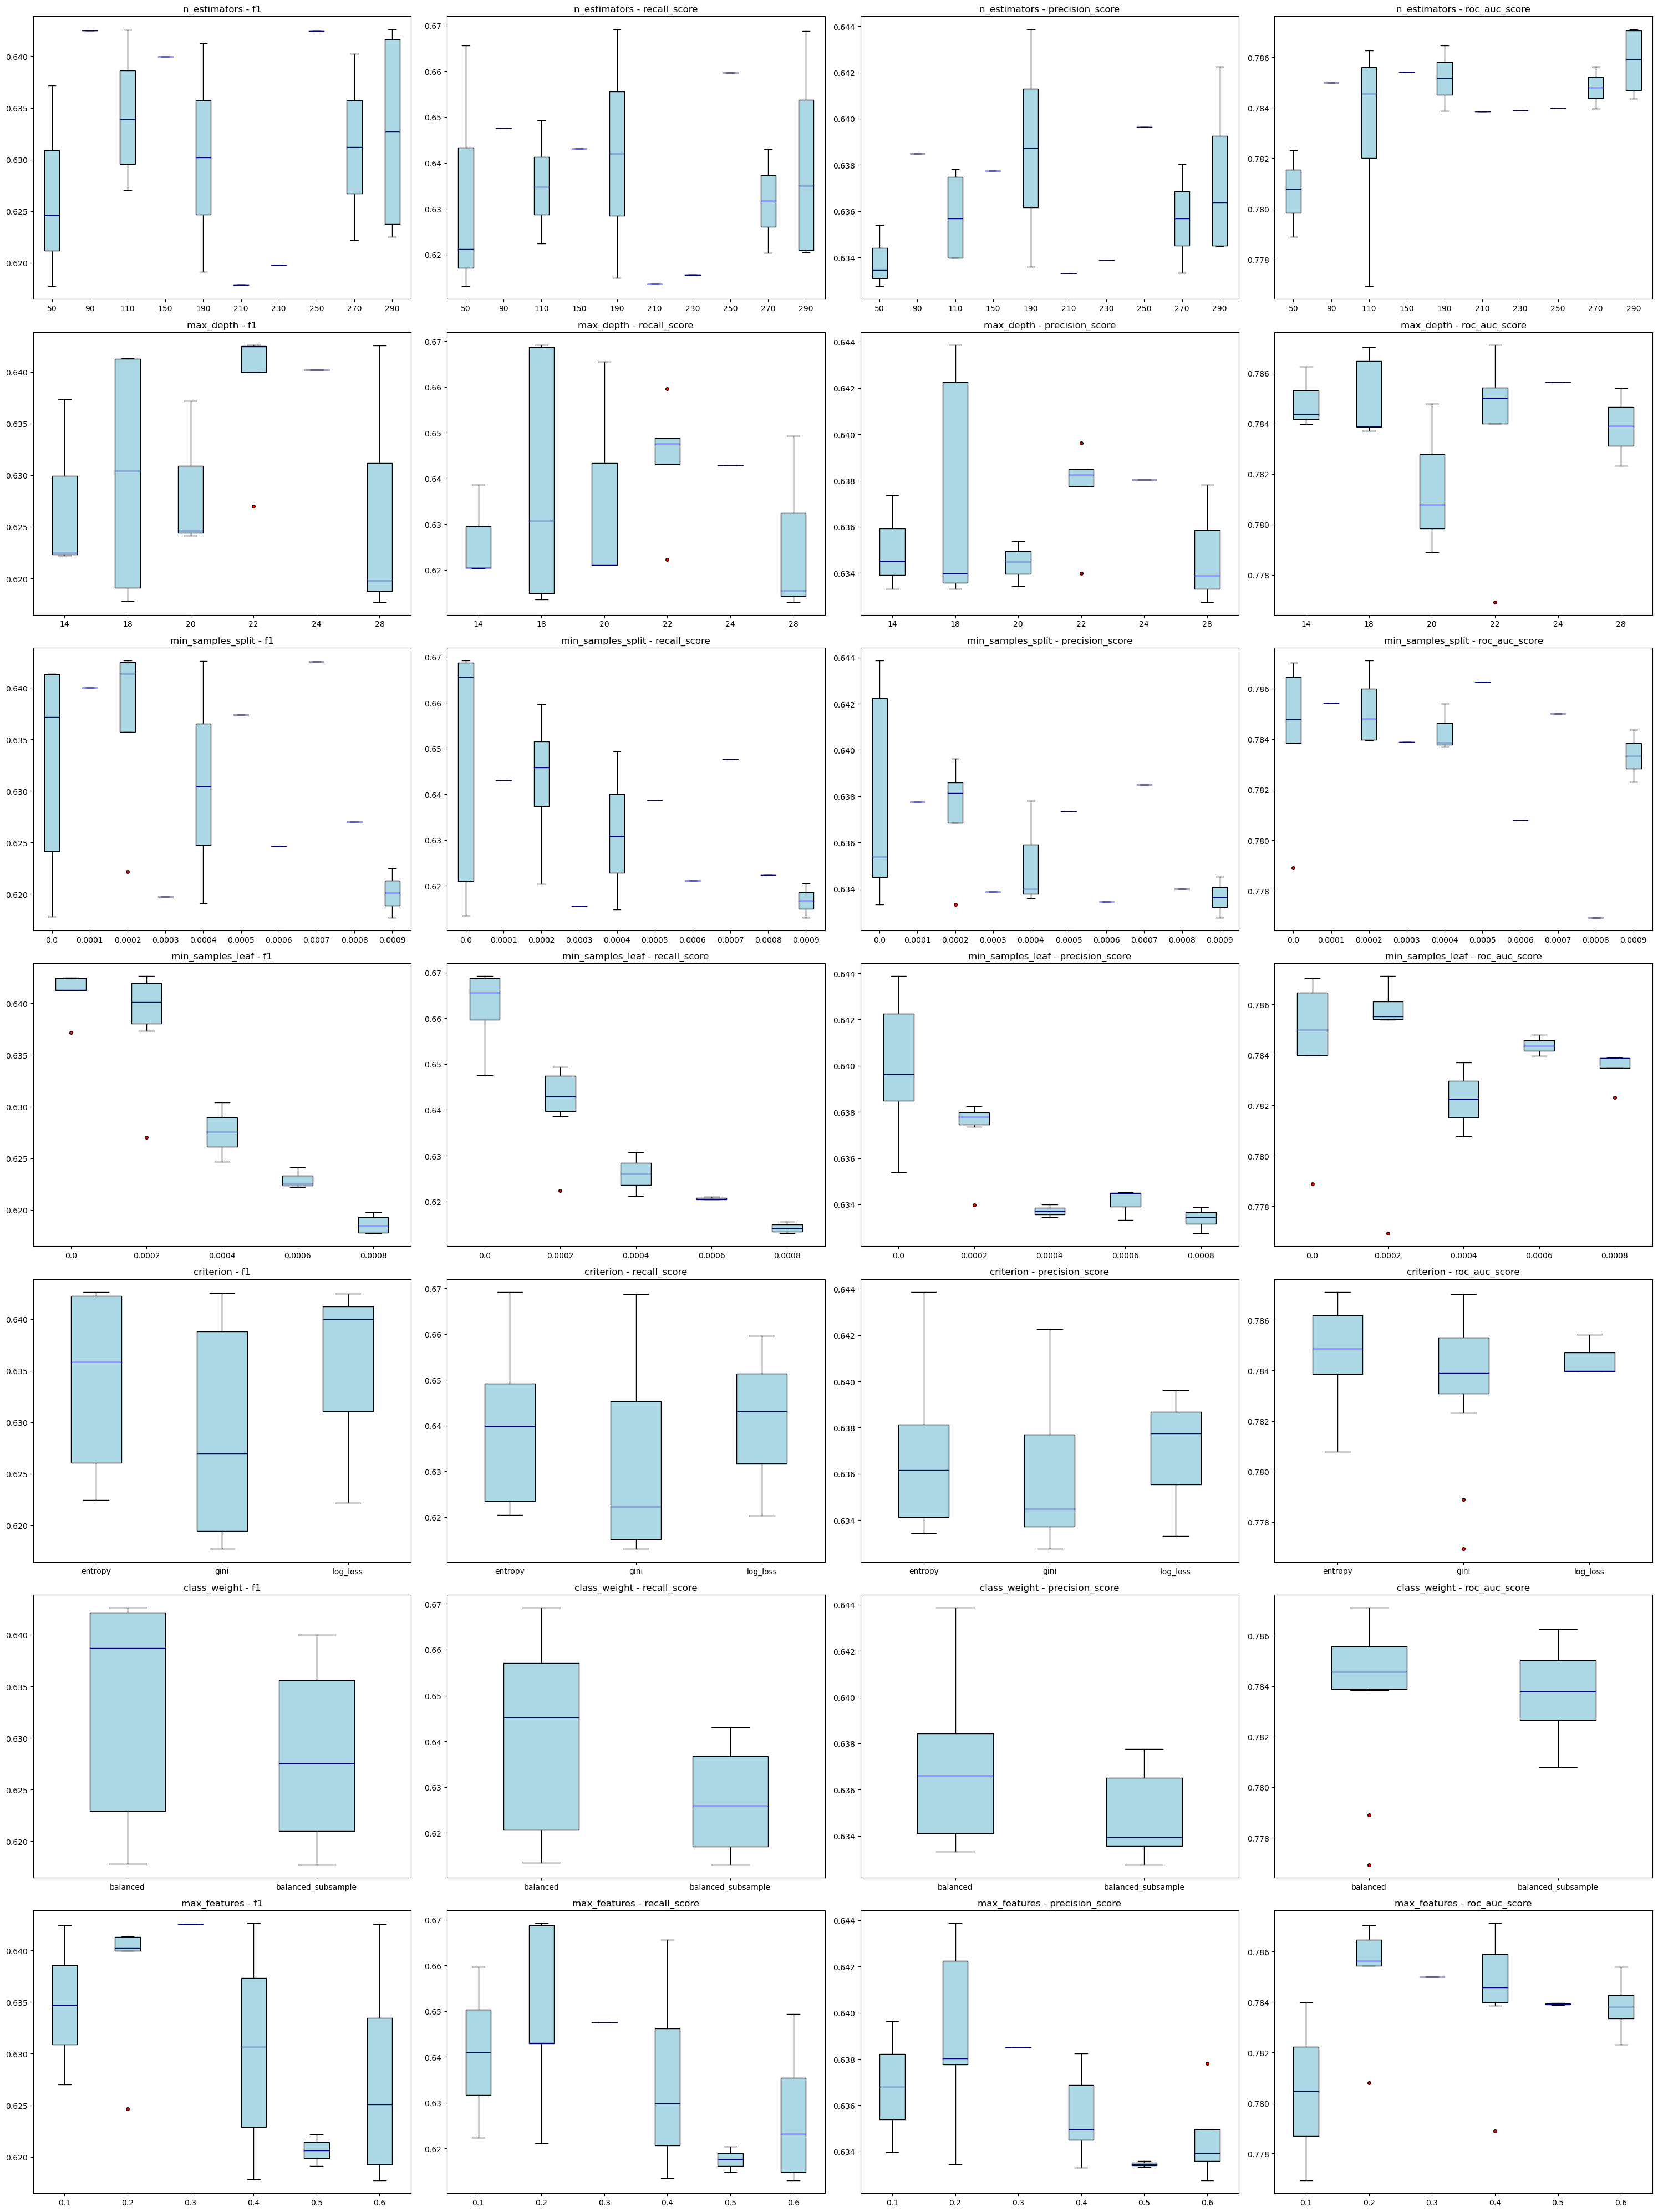

In [357]:
'''num_best_models = 20

best_models = sorted(result, key=lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(result, params, best_models, figsize_param=(30, 40))'''

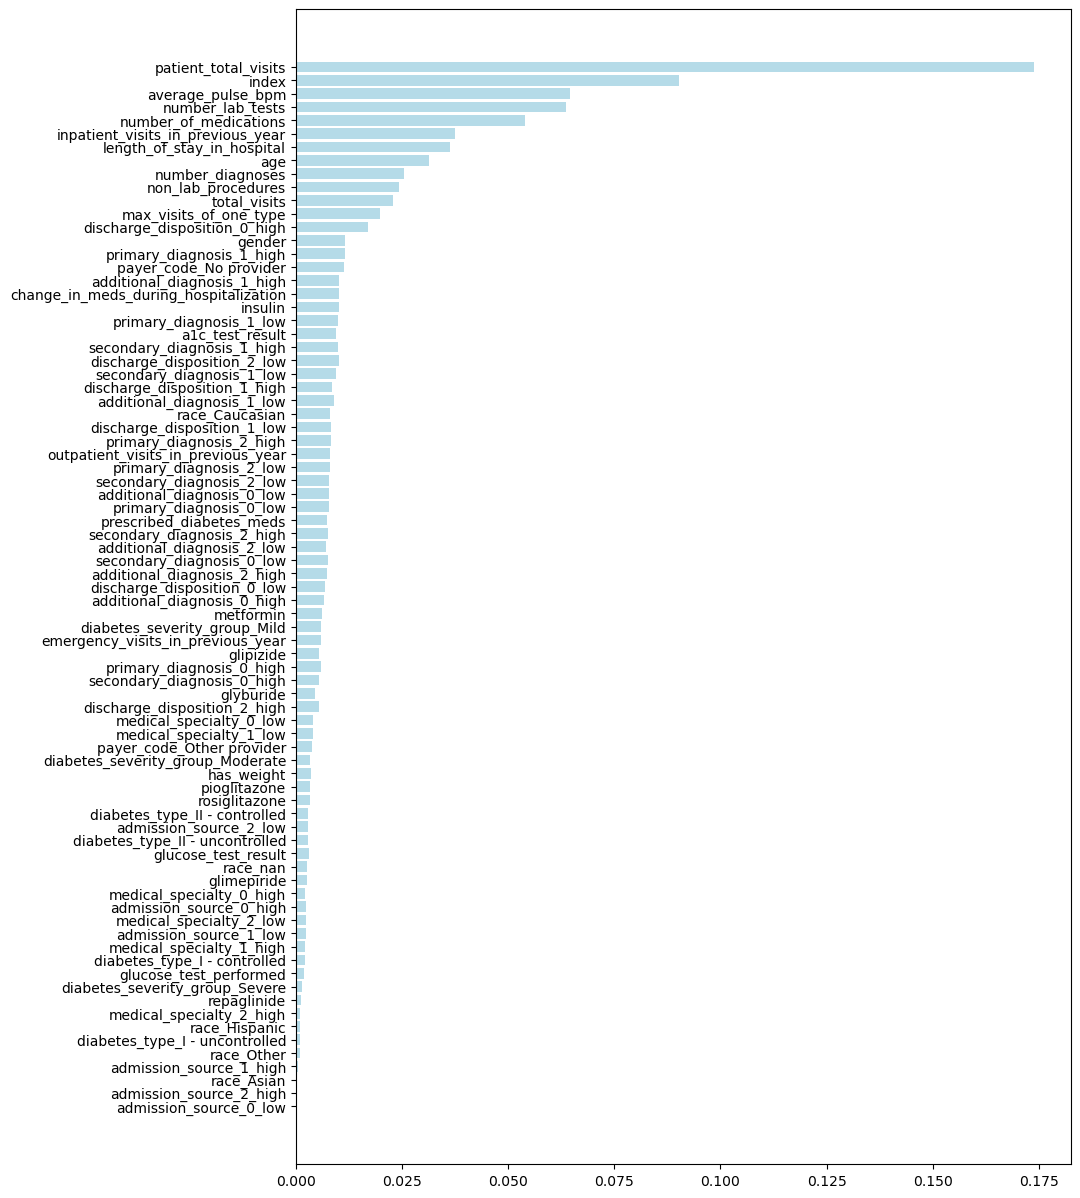

In [358]:
'''num_best_models = 10

best_models = sorted(result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

fdf = pd.DataFrame(np.array([best_models[k][4] for k in range(len(best_models))]).T)
fdf['features'] = best_models[0][3]
fdf.set_index('features', inplace = True)
ranked_df = fdf.rank(ascending=False)
ranked_df['median_rank'] = ranked_df.median(axis=1)
ranked_df['median_feature_importance'] = fdf.median(axis=1)
ranked_df.reset_index(inplace = True)
ranked_df = ranked_df[['features', 'median_rank', 'median_feature_importance']]
features = ranked_df.sort_values(by = 'median_rank').head(30)['features']


plt.figure(figsize=(10, 15))
plt.barh(ranked_df.sort_values(by = 'median_rank', ascending = False)['features'], 
         ranked_df.sort_values(by = 'median_rank', ascending = False)['median_feature_importance'],
         color='lightblue',  alpha=0.9, linewidth=0, height=0.8, align='center')
         
# plt.tight_layout()
plt.show()'''

In [359]:
'''model = RandomForestClassifier(random_state = random_state)
params = {
    'n_estimators': np.arange(50, 200, 10),
    'max_depth': np.arange(10, 20, 2),
    'min_samples_split': np.arange(0, 0.0008, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0.0002, 0.0008, 0.0002) + 0.000001,
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.2,0.5,0.1),
}

result_feature_selection = []
for i in tqdm(range(10)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
        
    for j in tqdm(range(0,80, 10)):

        features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
        features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))

        columns_to_use_full = list(set(columns_to_use).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
        columns_to_use_full.extend(['patient_id', 'encounter_id'])
                                   
        X_train = df_train[columns_to_use_full]
        y_train = df_train[target]
        
        data = pd.concat([X_train, y_train], axis = 1)
    
        result_feature_selection.append(
            (
                len(ranked_df)- j,
             cross_validation(data, 
                     target, 
                     model,
                     random_params,
                     multiclass= True,
                                   
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                              
                     upsample = False,   
                     cv=5)[1]
            )
        )'''

  0%|          | 0/10 [00:00<?, ?it/s]





100%|██████████| 5/5 [01:05<00:00, 13.19s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=90, random_state=42)
F1 train: 0.723, F1_val: 0.646








100%|██████████| 5/5 [01:03<00:00, 12.67s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=90, random_state=42)
F1 train: 0.724, F1_val: 0.646








100%|██████████| 5/5 [01:00<00:00, 12.03s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=90, random_state=42)
F1 train: 0.726, F1_val: 0.644








100%|██████████| 5/5 [00:56<00:00, 11.32s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=90, random_state=42)
F1 train: 0.726, F1_val: 0.642








100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=90, random_state=42)
F1 train: 0.724, F1_val: 0.641








100%|██████████| 5/5 [00:46<00:00,  9.22s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=90, random_state=42)
F1 train: 0.715, F1_val: 0.634








100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=90, random_state=42)
F1 train: 0.702, F1_val: 0.627








 10%|█         | 1/10 [06:54<1:02:08, 414.33s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=90, random_state=42)
F1 train: 0.672, F1_val: 0.605








100%|██████████| 5/5 [02:26<00:00, 29.28s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=180, random_state=42)
F1 train: 0.706, F1_val: 0.642








100%|██████████| 5/5 [01:42<00:00, 20.41s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=180, random_state=42)
F1 train: 0.706, F1_val: 0.641








100%|██████████| 5/5 [01:23<00:00, 16.68s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=180, random_state=42)
F1 train: 0.707, F1_val: 0.640








100%|██████████| 5/5 [01:19<00:00, 15.87s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=180, random_state=42)
F1 train: 0.707, F1_val: 0.640








100%|██████████| 5/5 [01:11<00:00, 14.27s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=180, random_state=42)
F1 train: 0.706, F1_val: 0.638








100%|██████████| 5/5 [01:05<00:00, 13.02s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=180, random_state=42)
F1 train: 0.696, F1_val: 0.632








100%|██████████| 5/5 [00:53<00:00, 10.73s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=180, random_state=42)
F1 train: 0.684, F1_val: 0.623








 20%|██        | 2/10 [17:36<1:13:08, 548.50s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=180, random_state=42)
F1 train: 0.661, F1_val: 0.600








100%|██████████| 5/5 [00:30<00:00,  6.01s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, random_state=42)
F1 train: 0.667, F1_val: 0.630








100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, random_state=42)
F1 train: 0.668, F1_val: 0.630








100%|██████████| 5/5 [00:25<00:00,  5.13s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, random_state=42)
F1 train: 0.669, F1_val: 0.629








100%|██████████| 5/5 [00:24<00:00,  4.80s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, random_state=42)
F1 train: 0.667, F1_val: 0.628








100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, random_state=42)
F1 train: 0.666, F1_val: 0.626








100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, random_state=42)
F1 train: 0.656, F1_val: 0.619








100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, random_state=42)
F1 train: 0.648, F1_val: 0.612








 30%|███       | 3/10 [20:35<44:17, 379.59s/it]  

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, random_state=42)
F1 train: 0.615, F1_val: 0.581








100%|██████████| 5/5 [01:31<00:00, 18.26s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.697, F1_val: 0.638








100%|██████████| 5/5 [01:28<00:00, 17.68s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.697, F1_val: 0.638








100%|██████████| 5/5 [01:22<00:00, 16.51s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.697, F1_val: 0.637








100%|██████████| 5/5 [01:16<00:00, 15.36s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.697, F1_val: 0.635








100%|██████████| 5/5 [01:09<00:00, 13.93s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.694, F1_val: 0.634








100%|██████████| 5/5 [01:01<00:00, 12.28s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.687, F1_val: 0.629








100%|██████████| 5/5 [00:52<00:00, 10.50s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.678, F1_val: 0.622








 40%|████      | 4/10 [29:58<45:11, 451.89s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.652, F1_val: 0.598








100%|██████████| 5/5 [00:47<00:00,  9.56s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.686, F1_val: 0.635








100%|██████████| 5/5 [00:45<00:00,  9.16s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.687, F1_val: 0.636








100%|██████████| 5/5 [00:43<00:00,  8.67s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.688, F1_val: 0.636








100%|██████████| 5/5 [00:40<00:00,  8.18s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.686, F1_val: 0.634








100%|██████████| 5/5 [00:37<00:00,  7.52s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.685, F1_val: 0.633








100%|██████████| 5/5 [00:33<00:00,  6.76s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.676, F1_val: 0.625








100%|██████████| 5/5 [00:29<00:00,  5.93s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.665, F1_val: 0.617








 50%|█████     | 5/10 [34:59<33:09, 397.81s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.632, F1_val: 0.588








100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.641, F1_val: 0.620








100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.641, F1_val: 0.619








100%|██████████| 5/5 [00:17<00:00,  3.40s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.641, F1_val: 0.619








100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.639, F1_val: 0.618








100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.640, F1_val: 0.618








100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.631, F1_val: 0.612








100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.624, F1_val: 0.604








 60%|██████    | 6/10 [36:56<20:08, 302.24s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.595, F1_val: 0.572








100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.645, F1_val: 0.622








100%|██████████| 5/5 [00:24<00:00,  4.89s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.646, F1_val: 0.623








100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.647, F1_val: 0.622








100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.645, F1_val: 0.620








100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.645, F1_val: 0.620








100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.635, F1_val: 0.613








100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.626, F1_val: 0.604








 70%|███████   | 7/10 [39:38<12:49, 256.48s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.593, F1_val: 0.567








100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.658, F1_val: 0.625








100%|██████████| 5/5 [00:27<00:00,  5.57s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.659, F1_val: 0.626








100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.658, F1_val: 0.625








100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.657, F1_val: 0.625








100%|██████████| 5/5 [00:22<00:00,  4.40s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.656, F1_val: 0.622








100%|██████████| 5/5 [00:19<00:00,  3.89s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.649, F1_val: 0.617








100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.640, F1_val: 0.608








 80%|████████  | 8/10 [42:36<07:42, 231.25s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.610, F1_val: 0.579








100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000101, n_estimators=80,
                       random_state=42)
F1 train: 0.745, F1_val: 0.647








100%|██████████| 5/5 [00:30<00:00,  6.12s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000101, n_estimators=80,
                       random_state=42)
F1 train: 0.745, F1_val: 0.647








100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000101, n_estimators=80,
                       random_state=42)
F1 train: 0.746, F1_val: 0.644








100%|██████████| 5/5 [00:26<00:00,  5.38s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000101, n_estimators=80,
                       random_state=42)
F1 train: 0.744, F1_val: 0.644








100%|██████████| 5/5 [00:24<00:00,  4.91s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000101, n_estimators=80,
                       random_state=42)
F1 train: 0.740, F1_val: 0.643








100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000101, n_estimators=80,
                       random_state=42)
F1 train: 0.727, F1_val: 0.633








100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000101, n_estimators=80,
                       random_state=42)
F1 train: 0.717, F1_val: 0.629








 90%|█████████ | 9/10 [45:55<03:41, 221.37s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000101, n_estimators=80,
                       random_state=42)
F1 train: 0.686, F1_val: 0.608








100%|██████████| 5/5 [01:21<00:00, 16.24s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=140, random_state=42)
F1 train: 0.709, F1_val: 0.640








100%|██████████| 5/5 [01:17<00:00, 15.49s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=140, random_state=42)
F1 train: 0.710, F1_val: 0.640








100%|██████████| 5/5 [01:12<00:00, 14.46s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=140, random_state=42)
F1 train: 0.710, F1_val: 0.640








100%|██████████| 5/5 [01:06<00:00, 13.32s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=140, random_state=42)
F1 train: 0.707, F1_val: 0.637








100%|██████████| 5/5 [01:00<00:00, 12.06s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=140, random_state=42)
F1 train: 0.704, F1_val: 0.636








100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=140, random_state=42)
F1 train: 0.695, F1_val: 0.630








100%|██████████| 5/5 [00:45<00:00,  9.12s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=140, random_state=42)
F1 train: 0.686, F1_val: 0.623








100%|██████████| 10/10 [54:08<00:00, 324.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=140, random_state=42)
F1 train: 0.663, F1_val: 0.603


In [360]:
'''import pickle


# Store the list using pickle
with open('Learning_results/rf_feature_selection_num_features_mc.pkl', 'wb') as file:
    pickle.dump(result_feature_selection, file)'''

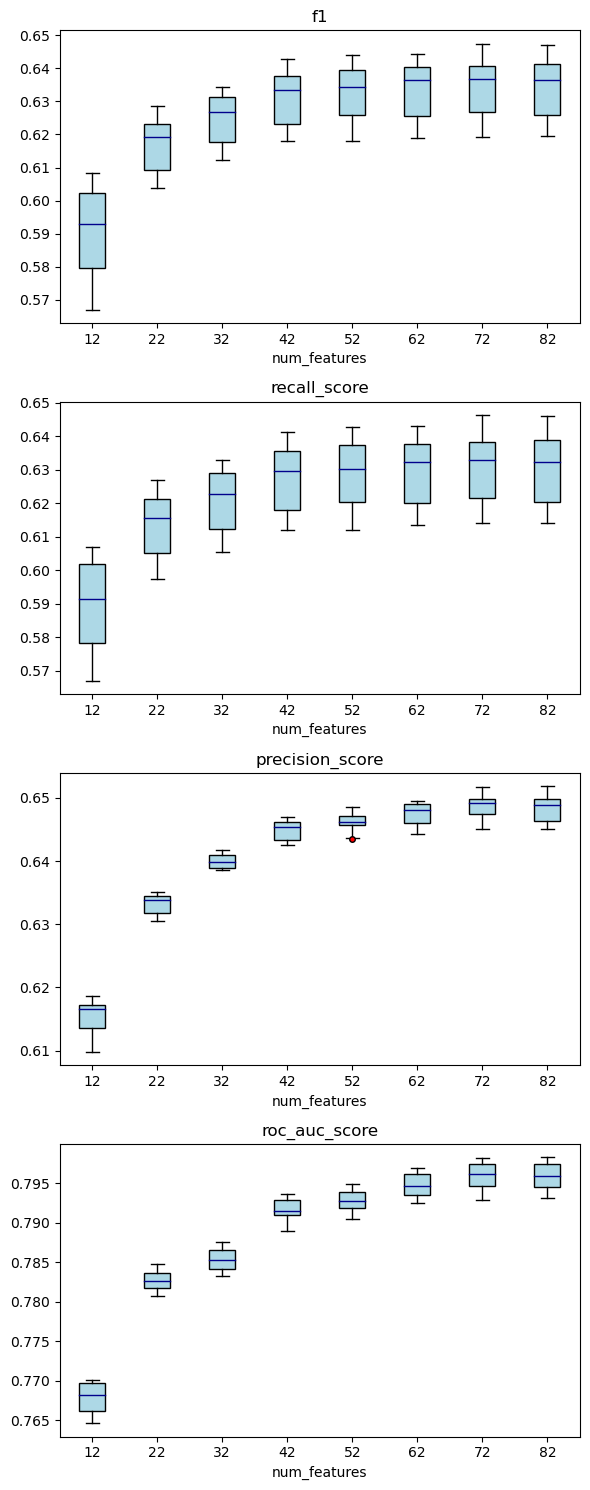

In [361]:
'''result_feature_selection_df = pd.DataFrame(result_feature_selection)

result_feature_selection_df[list(result_feature_selection_df[1][0].keys())] = pd.DataFrame(result_feature_selection_df[1].apply(lambda x: [x[i][1] for i in x.keys()]).apply(pd.Series)
)

result_feature_selection_df.rename(columns={0: 'num_features'}, inplace=True)
fig,ax = plt.subplots( nrows = len(list(result_feature_selection_df[1][0].keys())), figsize = (6,15))
result_feature_selection_df = result_feature_selection_df.sort_values(by='num_features')

for m in range(len(list(result_feature_selection_df[1][0].keys()))):
    metric = list(result_feature_selection_df[1][0].keys())[m]
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).max())
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).min())
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).median())

    ax[m].boxplot([group[1][metric].values for group in result_feature_selection_df.groupby('num_features')],
            labels = result_feature_selection_df['num_features'].unique()+3,
            patch_artist=True,
            widths=0.4,         
            medianprops=dict(color='darkblue'),
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
             whiskerprops=dict(color='black'), 
             capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=4) )
                       
    ax[m].set_title(metric)
    ax[m].set_xlabel('num_features')

plt.tight_layout()
plt.show()'''

In [362]:
'''# Redefine data with new selected 50 columns 
features =  list(set(list(ranked_df.sort_values(by = 'median_rank').head(50)['features'])).intersection(set(columns_to_use)))
features.extend(['encounter_id', 'patient_id'])
X_train = df_train[features]
y_train = df_train[target]

features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(set(features)))
features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(set(features)))

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_multiclass'

with open('Learning_results/selected_features_rf_mc.pkl', 'wb') as file:
    pickle.dump(features, file)'''

#### Logistic Regression

In [363]:
'''features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result','a1c_test_result'
                              ]
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

columns_to_use_full = columns_to_use #+ features_for_encoding

X_train = df_train[columns_to_use_full]
y_train = df_train[target]

data = pd.concat([X_train, y_train], axis = 1)'''


In [364]:
'''model = LogisticRegression(solver='sag', max_iter = 200, 
                           class_weight = 'balanced', random_state = random_state )
params = {
    'penalty': 'l2',
    'max_iter': 1000
}

result_log_reg = []
result_log_reg.append(cross_validation(data, 
                 target, 
                 model, 
                 params,     
                 multiclass= True,           
                 scaling = True,
                 features_for_scaling_minmax = features_for_scaling_minmax,
                 features_for_scaling_standard = features_for_scaling_standard,
                 cv=5))'''

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:21<00:00, 40.24s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.604, F1_val: 0.608


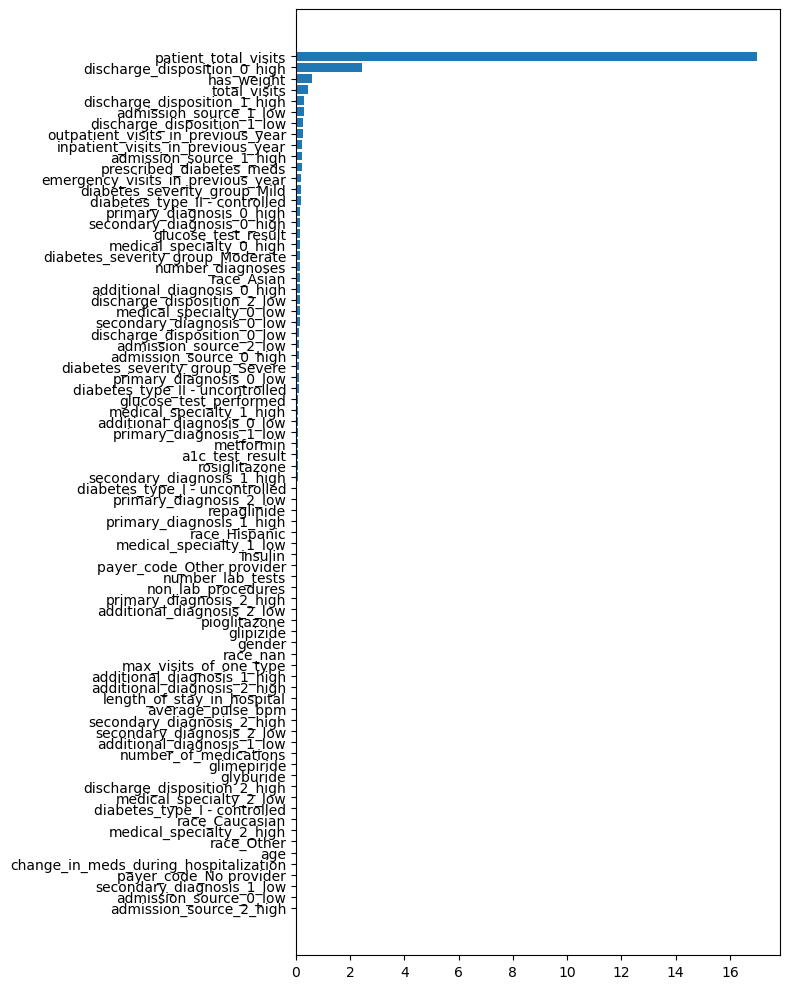

In [365]:
'''fdf = pd.DataFrame(np.abs(result_log_reg[0][-1][0]), columns = ['coef'])
fdf['features'] = result_log_reg[0][3]
fdf.set_index('features', inplace = True)
fdf['rank'] = fdf.rank(ascending=False)
fdf.reset_index(inplace = True)

plt.figure(figsize=(8, 10))
plt.barh(fdf.sort_values(by = 'rank', ascending = False)['features'], fdf.sort_values(by = 'rank', ascending = False)['coef'])
plt.tight_layout()
plt.show()'''

In [366]:
'''model = LogisticRegression(solver='sag', max_iter = 200, 
                           class_weight = 'balanced', random_state = random_state )
params = {
    'penalty': 'l2',
    'max_iter': 1000
}
result_feature_selection = []

for j in tqdm(range(40,70, 3)):

    features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
    features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))

    columns_to_use_full = list(set(columns_to_use).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
    columns_to_use_full.extend(['patient_id', 'encounter_id'])
                               
    X_train = df_train[columns_to_use_full]
    y_train = df_train[target]

    data = pd.concat([X_train, y_train], axis = 1)

    result_feature_selection.append(
        (
            len(ranked_df)- j,
         cross_validation(data, 
                 target, 
                 model,
                 params,
                 multiclass=True,
                               
                 scaling = True,
                 features_for_scaling_minmax = features_for_scaling_minmax,
                 features_for_scaling_standard = features_for_scaling_standard,
                          
                 upsample = False,   
                 cv=5)[1]
        )
    )'''

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:42<15:20, 102.33s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.599, F1_val: 0.604


 20%|██        | 2/10 [03:18<13:07, 98.43s/it] 

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.598, F1_val: 0.604


 30%|███       | 3/10 [04:43<10:49, 92.73s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.596, F1_val: 0.603


 40%|████      | 4/10 [06:04<08:47, 87.87s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.591, F1_val: 0.599


 50%|█████     | 5/10 [07:16<06:50, 82.11s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.588, F1_val: 0.596


 60%|██████    | 6/10 [08:20<05:04, 76.15s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.588, F1_val: 0.596


 70%|███████   | 7/10 [09:19<03:31, 70.40s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.583, F1_val: 0.592


 80%|████████  | 8/10 [10:09<02:08, 64.03s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.582, F1_val: 0.591


 90%|█████████ | 9/10 [10:54<00:57, 57.92s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.585, F1_val: 0.594


100%|██████████| 10/10 [11:34<00:00, 69.44s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.576, F1_val: 0.584


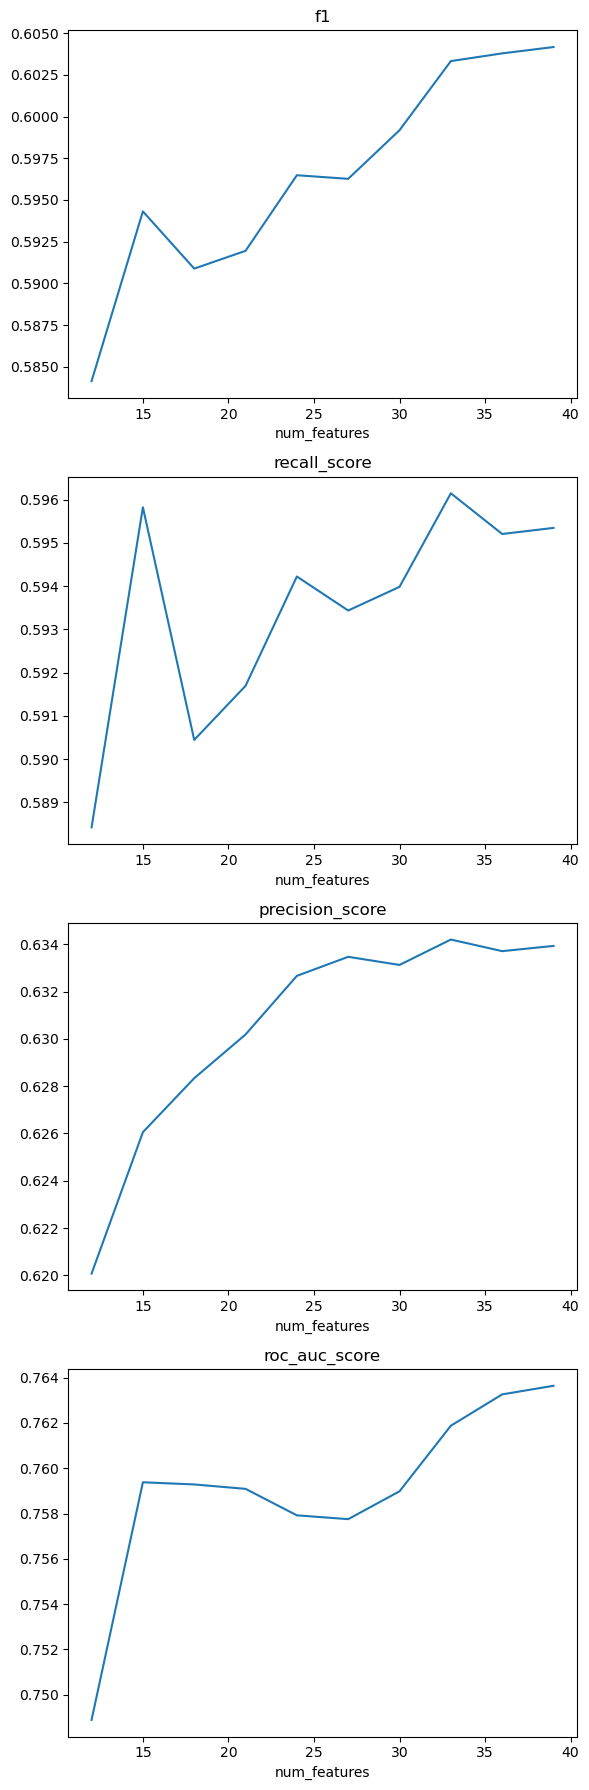

In [367]:
'''result_feature_selection_df = pd.DataFrame(result_feature_selection)

result_feature_selection_df[list(result_feature_selection_df[1][0].keys())] = pd.DataFrame(result_feature_selection_df[1].apply(lambda x: [x[i][1] for i in x.keys()]).apply(pd.Series)
)

result_feature_selection_df.rename(columns={0: 'num_features'}, inplace=True)
fig,ax = plt.subplots( nrows = len(list(result_feature_selection_df[1][0].keys())), figsize = (6,18))
result_feature_selection_df = result_feature_selection_df.sort_values(by='num_features')

for m in range(len(list(result_feature_selection_df[1][0].keys()))):
    metric = list(result_feature_selection_df[1][0].keys())[m]

    ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).median())
                       
    ax[m].set_title(metric)
    ax[m].set_xlabel('num_features')

plt.tight_layout()
plt.show()'''

### Model Selection

In [394]:
'''with open('Learning_results/selected_features_rf_mc.pkl', 'rb') as file:
    # Load the pickled data
    features = pickle.load(file)


features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result','a1c_test_result']

features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

X_train = df_train[features]
y_train = df_train[target]
X_test = X_test[features]

features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(set(features)))
features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(set(features)))

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_multiclass'''

#### Random Forest

In [369]:
'''model = RandomForestClassifier(random_state = random_state)
rf_params = {
    'n_estimators': np.arange(100, 200, 10),
    'max_depth': np.arange(10, 30, 2),
    'min_samples_split': np.arange(0.0002, 0.001, 0.0001),
    'min_samples_leaf': np.arange(0.0002, 0.001, 0.0001),
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.1,0.9,0.1),
}

rf_result = []
for i in tqdm(range(30)):
    random_params = {}
    for key, values in rf_params.items():
        random_params[key] = random.choice(values)
    rf_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params,
                     multiclass=True,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,    
                     upsample = False,   
                     cv=5))'''

  1%|          | 1/100 [00:57<1:34:06, 57.04s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0008, n_estimators=180,
                       random_state=42)
F1 train: 0.648, F1_val: 0.620


  2%|▏         | 2/100 [01:15<55:44, 34.13s/it]  

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.1,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0008, n_estimators=130,
                       random_state=42)
F1 train: 0.620, F1_val: 0.607


  3%|▎         | 3/100 [02:32<1:27:11, 53.93s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.6, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.673, F1_val: 0.628


  4%|▍         | 4/100 [03:43<1:36:48, 60.51s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.7000000000000001, min_samples_leaf=0.0005,
                       min_samples_split=0.0009000000000000001,
                       random_state=42)
F1 train: 0.698, F1_val: 0.634


  5%|▌         | 5/100 [04:07<1:14:55, 47.33s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.1, min_samples_leaf=0.0008,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=120, random_state=42)
F1 train: 0.632, F1_val: 0.611


  6%|▌         | 6/100 [04:38<1:05:50, 42.02s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.1, min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.616, F1_val: 0.606


  7%|▋         | 7/100 [05:06<58:00, 37.42s/it]  

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.2, min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0002, random_state=42)
F1 train: 0.642, F1_val: 0.617


  8%|▊         | 8/100 [05:35<53:01, 34.58s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.2, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0006000000000000001,
                       random_state=42)
F1 train: 0.646, F1_val: 0.620


  9%|▉         | 9/100 [07:21<1:26:25, 56.98s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.719, F1_val: 0.639


 10%|█         | 10/100 [07:59<1:16:37, 51.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.1,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0002, n_estimators=180,
                       random_state=42)
F1 train: 0.685, F1_val: 0.629


 11%|█         | 11/100 [09:01<1:20:51, 54.52s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=140, random_state=42)
F1 train: 0.696, F1_val: 0.635


 12%|█▏        | 12/100 [10:08<1:25:12, 58.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0005, min_samples_split=0.0005,
                       n_estimators=180, random_state=42)
F1 train: 0.684, F1_val: 0.631


 13%|█▎        | 13/100 [10:36<1:11:10, 49.08s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.1, min_samples_leaf=0.0002,
                       min_samples_split=0.0002, n_estimators=130,
                       random_state=42)
F1 train: 0.707, F1_val: 0.635


 14%|█▍        | 14/100 [11:06<1:02:05, 43.32s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.2, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.655, F1_val: 0.621


 15%|█▌        | 15/100 [12:18<1:13:39, 51.99s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.7000000000000001, min_samples_leaf=0.0005,
                       min_samples_split=0.0009000000000000001,
                       random_state=42)
F1 train: 0.696, F1_val: 0.635


 16%|█▌        | 16/100 [14:11<1:38:25, 70.30s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26,
                       max_features=0.7000000000000001, min_samples_leaf=0.0005,
                       min_samples_split=0.0002, n_estimators=160,
                       random_state=42)
F1 train: 0.699, F1_val: 0.635


 17%|█▋        | 17/100 [16:37<2:08:56, 93.21s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features=0.7000000000000001, min_samples_leaf=0.0002,
                       min_samples_split=0.0008, n_estimators=190,
                       random_state=42)
F1 train: 0.746, F1_val: 0.645


 18%|█▊        | 18/100 [17:43<1:56:12, 85.03s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.691, F1_val: 0.634


 19%|█▉        | 19/100 [18:14<1:32:49, 68.75s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.647, F1_val: 0.620


 20%|██        | 20/100 [20:06<1:49:05, 81.82s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.7000000000000001, min_samples_leaf=0.0002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=140, random_state=42)
F1 train: 0.757, F1_val: 0.647


 21%|██        | 21/100 [22:28<2:11:28, 99.85s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.7000000000000001, min_samples_leaf=0.0002,
                       min_samples_split=0.0008, n_estimators=190,
                       random_state=42)
F1 train: 0.743, F1_val: 0.645


 22%|██▏       | 22/100 [23:04<1:44:47, 80.62s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.2,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0002, n_estimators=140,
                       random_state=42)
F1 train: 0.655, F1_val: 0.622


 23%|██▎       | 23/100 [24:01<1:34:26, 73.59s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.4, min_samples_leaf=0.0002,
                       min_samples_split=0.0008, n_estimators=110,
                       random_state=42)
F1 train: 0.734, F1_val: 0.642


 24%|██▍       | 24/100 [25:39<1:42:35, 80.99s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.8,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=140, random_state=42)
F1 train: 0.658, F1_val: 0.623


 25%|██▌       | 25/100 [26:00<1:18:25, 62.74s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.1,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0005, n_estimators=130,
                       random_state=42)
F1 train: 0.627, F1_val: 0.609


 26%|██▌       | 26/100 [27:58<1:37:49, 79.31s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=160, random_state=42)
F1 train: 0.720, F1_val: 0.640


 27%|██▋       | 27/100 [29:48<1:48:00, 88.77s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.6, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.717, F1_val: 0.639


 28%|██▊       | 28/100 [30:20<1:26:01, 71.69s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.1, min_samples_leaf=0.0005,
                       min_samples_split=0.0005, n_estimators=160,
                       random_state=42)
F1 train: 0.653, F1_val: 0.619


 29%|██▉       | 29/100 [31:56<1:33:26, 78.97s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.5,
                       min_samples_leaf=0.0002, min_samples_split=0.0002,
                       n_estimators=180, random_state=42)
F1 train: 0.743, F1_val: 0.646


 30%|███       | 30/100 [32:29<1:15:59, 65.13s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.2,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=140, random_state=42)
F1 train: 0.642, F1_val: 0.617


 31%|███       | 31/100 [34:26<1:32:36, 80.54s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.668, F1_val: 0.627


 32%|███▏      | 32/100 [34:54<1:13:32, 64.89s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.1,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0008, n_estimators=170,
                       random_state=42)
F1 train: 0.660, F1_val: 0.622


 33%|███▎      | 33/100 [36:52<1:30:18, 80.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features=0.7000000000000001, min_samples_leaf=0.0008,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=190, random_state=42)
F1 train: 0.666, F1_val: 0.626


 34%|███▍      | 34/100 [37:58<1:23:56, 76.32s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.6, min_samples_leaf=0.0005,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=110, random_state=42)
F1 train: 0.688, F1_val: 0.633


 35%|███▌      | 35/100 [38:39<1:11:15, 65.77s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.655, F1_val: 0.624


 36%|███▌      | 36/100 [39:03<56:52, 53.32s/it]  

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=120, random_state=42)
F1 train: 0.629, F1_val: 0.613


 37%|███▋      | 37/100 [39:47<52:51, 50.34s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.2,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.662, F1_val: 0.626


 38%|███▊      | 38/100 [40:16<45:24, 43.94s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0002, n_estimators=120,
                       random_state=42)
F1 train: 0.666, F1_val: 0.628


 39%|███▉      | 39/100 [41:15<49:15, 48.45s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.670, F1_val: 0.628


 40%|████      | 40/100 [42:20<53:39, 53.66s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.4, min_samples_leaf=0.0002,
                       min_samples_split=0.0008, n_estimators=130,
                       random_state=42)
F1 train: 0.734, F1_val: 0.643


 41%|████      | 41/100 [42:52<46:06, 46.90s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.2,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0009000000000000001,
                       random_state=42)
F1 train: 0.696, F1_val: 0.634


 42%|████▏     | 42/100 [44:07<53:34, 55.42s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.8, min_samples_leaf=0.0008,
                       min_samples_split=0.0006000000000000001,
                       random_state=42)
F1 train: 0.667, F1_val: 0.625


 43%|████▎     | 43/100 [44:55<50:37, 53.29s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0008, min_samples_split=0.0008,
                       n_estimators=150, random_state=42)
F1 train: 0.655, F1_val: 0.621


 44%|████▍     | 44/100 [46:14<56:49, 60.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.4,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0008, n_estimators=170,
                       random_state=42)
F1 train: 0.720, F1_val: 0.640


 45%|████▌     | 45/100 [46:46<47:50, 52.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.2,
                       min_samples_leaf=0.0008, min_samples_split=0.0008,
                       n_estimators=130, random_state=42)
F1 train: 0.648, F1_val: 0.619


 46%|████▌     | 46/100 [47:19<41:51, 46.51s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.2, min_samples_leaf=0.0008,
                       min_samples_split=0.0008, n_estimators=120,
                       random_state=42)
F1 train: 0.648, F1_val: 0.620


 47%|████▋     | 47/100 [47:51<37:12, 42.13s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.2,
                       min_samples_leaf=0.0008,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.648, F1_val: 0.620


 48%|████▊     | 48/100 [48:50<40:54, 47.20s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=140, random_state=42)
F1 train: 0.737, F1_val: 0.645


 49%|████▉     | 49/100 [50:28<52:58, 62.33s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.5, min_samples_leaf=0.0008,
                       min_samples_split=0.0008, n_estimators=190,
                       random_state=42)
F1 train: 0.662, F1_val: 0.624


 50%|█████     | 50/100 [52:52<1:12:32, 87.05s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.8,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=170,
                       random_state=42)
F1 train: 0.738, F1_val: 0.643


 51%|█████     | 51/100 [53:28<58:24, 71.52s/it]  

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.1, min_samples_leaf=0.0002,
                       min_samples_split=0.0008, n_estimators=160,
                       random_state=42)
F1 train: 0.694, F1_val: 0.631


 52%|█████▏    | 52/100 [54:24<53:40, 67.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.5, min_samples_leaf=0.0008,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.661, F1_val: 0.623


 53%|█████▎    | 53/100 [55:44<55:28, 70.82s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.718, F1_val: 0.639


 54%|█████▍    | 54/100 [57:26<1:01:26, 80.14s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.8,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.701, F1_val: 0.635


 55%|█████▌    | 55/100 [58:17<53:40, 71.56s/it]  

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.5, min_samples_leaf=0.0008,
                       min_samples_split=0.0006000000000000001,
                       random_state=42)
F1 train: 0.661, F1_val: 0.624


 56%|█████▌    | 56/100 [1:00:10<1:01:26, 83.78s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.658, F1_val: 0.623


 57%|█████▋    | 57/100 [1:00:40<48:41, 67.93s/it]  

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.1,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.660, F1_val: 0.622


 58%|█████▊    | 58/100 [1:01:37<45:05, 64.40s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.6, min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0005, n_estimators=110,
                       random_state=42)
F1 train: 0.646, F1_val: 0.621


 59%|█████▉    | 59/100 [1:03:52<58:30, 85.63s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.8, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0008, n_estimators=160,
                       random_state=42)
F1 train: 0.722, F1_val: 0.640


 60%|██████    | 60/100 [1:04:17<44:58, 67.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26, max_features=0.1,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.685, F1_val: 0.629


 61%|██████    | 61/100 [1:04:40<35:07, 54.03s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.1,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=130, random_state=42)
F1 train: 0.654, F1_val: 0.619


 62%|██████▏   | 62/100 [1:05:36<34:41, 54.79s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.2, min_samples_leaf=0.0002,
                       min_samples_split=0.0008, n_estimators=180,
                       random_state=42)
F1 train: 0.714, F1_val: 0.640


 63%|██████▎   | 63/100 [1:06:44<36:07, 58.59s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0008,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.655, F1_val: 0.622


 64%|██████▍   | 64/100 [1:07:30<32:54, 54.85s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.2,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.663, F1_val: 0.625


 65%|██████▌   | 65/100 [1:08:12<29:46, 51.05s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.4,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=120, random_state=42)
F1 train: 0.660, F1_val: 0.627


 66%|██████▌   | 66/100 [1:08:35<24:07, 42.56s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.1,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=140,
                       random_state=42)
F1 train: 0.636, F1_val: 0.614


 67%|██████▋   | 67/100 [1:09:30<25:32, 46.43s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.5, min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0008, n_estimators=110,
                       random_state=42)
F1 train: 0.655, F1_val: 0.622


 68%|██████▊   | 68/100 [1:11:14<34:00, 63.76s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.5, min_samples_leaf=0.0005,
                       min_samples_split=0.0002, n_estimators=180,
                       random_state=42)
F1 train: 0.694, F1_val: 0.634


 69%|██████▉   | 69/100 [1:13:02<39:42, 76.84s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.6,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0008, n_estimators=190,
                       random_state=42)
F1 train: 0.656, F1_val: 0.623


 70%|███████   | 70/100 [1:14:06<36:36, 73.23s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.4, min_samples_leaf=0.0008,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.659, F1_val: 0.625


 71%|███████   | 71/100 [1:15:45<39:00, 80.71s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.696, F1_val: 0.636


 72%|███████▏  | 72/100 [1:17:20<39:39, 84.98s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.4, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.641, F1_val: 0.619


 73%|███████▎  | 73/100 [1:18:29<36:11, 80.44s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.2,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0005, n_estimators=160,
                       random_state=42)
F1 train: 0.690, F1_val: 0.633


 74%|███████▍  | 74/100 [1:19:50<34:50, 80.42s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.2, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0008, n_estimators=180,
                       random_state=42)
F1 train: 0.656, F1_val: 0.623


 75%|███████▌  | 75/100 [1:21:02<32:26, 77.87s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       random_state=42)
F1 train: 0.707, F1_val: 0.637


 76%|███████▌  | 76/100 [1:23:26<39:07, 97.80s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.8,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=130, random_state=42)
F1 train: 0.660, F1_val: 0.623


 77%|███████▋  | 77/100 [1:24:46<35:25, 92.42s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.671, F1_val: 0.628


 78%|███████▊  | 78/100 [1:26:38<36:01, 98.24s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.6, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0005, n_estimators=120,
                       random_state=42)
F1 train: 0.684, F1_val: 0.633


 79%|███████▉  | 79/100 [1:27:35<30:05, 85.95s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0002, min_samples_split=0.0008,
                       n_estimators=110, random_state=42)
F1 train: 0.686, F1_val: 0.633


 80%|████████  | 80/100 [1:28:10<23:32, 70.62s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.1,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0008, n_estimators=140,
                       random_state=42)
F1 train: 0.627, F1_val: 0.609


 81%|████████  | 81/100 [1:29:12<21:33, 68.09s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0002, n_estimators=120,
                       random_state=42)
F1 train: 0.667, F1_val: 0.626


 82%|████████▏ | 82/100 [1:32:08<30:05, 100.32s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=170, random_state=42)
F1 train: 0.675, F1_val: 0.629


 83%|████████▎ | 83/100 [1:34:05<29:52, 105.42s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.8,
                       min_samples_leaf=0.0008,
                       min_samples_split=0.0006000000000000001,
                       random_state=42)
F1 train: 0.666, F1_val: 0.625


 84%|████████▍ | 84/100 [1:35:31<26:34, 99.63s/it] 

RandomForestClassifier(class_weight='balanced', max_depth=18, max_features=0.5,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=110,
                       random_state=42)
F1 train: 0.670, F1_val: 0.627


 85%|████████▌ | 85/100 [1:36:47<23:09, 92.66s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.5,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.00030000000000000003,
                       random_state=42)
F1 train: 0.693, F1_val: 0.635


 86%|████████▌ | 86/100 [1:39:00<24:23, 104.56s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.4, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=190,
                       random_state=42)
F1 train: 0.667, F1_val: 0.626


 87%|████████▋ | 87/100 [1:39:38<18:19, 84.61s/it] 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.2, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0004000000000000001,
                       random_state=42)
F1 train: 0.634, F1_val: 0.616


 88%|████████▊ | 88/100 [1:42:38<22:39, 113.30s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.6,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.717, F1_val: 0.640


 89%|████████▉ | 89/100 [1:45:38<24:27, 133.44s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.6, min_samples_leaf=0.0005,
                       min_samples_split=0.0008, n_estimators=180,
                       random_state=42)
F1 train: 0.697, F1_val: 0.635


 90%|█████████ | 90/100 [1:47:46<21:56, 131.68s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0005, n_estimators=120,
                       random_state=42)
F1 train: 0.684, F1_val: 0.631


 91%|█████████ | 91/100 [1:48:37<16:06, 107.38s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.657, F1_val: 0.625


 92%|█████████▏| 92/100 [1:50:48<15:17, 114.66s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.5, min_samples_leaf=0.0002,
                       min_samples_split=0.0008, n_estimators=140,
                       random_state=42)
F1 train: 0.738, F1_val: 0.645


 93%|█████████▎| 93/100 [1:52:56<13:49, 118.44s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.8, min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.659, F1_val: 0.624


 94%|█████████▍| 94/100 [1:55:45<13:22, 133.78s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.683, F1_val: 0.631


 95%|█████████▌| 95/100 [1:56:53<09:30, 114.05s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0004000000000000001,
                       random_state=42)
F1 train: 0.764, F1_val: 0.648


 96%|█████████▌| 96/100 [1:59:45<08:45, 131.31s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.8, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.716, F1_val: 0.640


 97%|█████████▋| 97/100 [2:01:35<06:14, 124.97s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=190,
                       random_state=42)
F1 train: 0.663, F1_val: 0.625


 98%|█████████▊| 98/100 [2:04:08<04:26, 133.32s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.6, min_samples_leaf=0.0008,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.664, F1_val: 0.625


 99%|█████████▉| 99/100 [2:06:26<02:14, 134.77s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.6, min_samples_leaf=0.0002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=120, random_state=42)
F1 train: 0.764, F1_val: 0.648


100%|██████████| 100/100 [2:07:21<00:00, 76.42s/it] 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.1, min_samples_leaf=0.0008,
                       min_samples_split=0.0008, n_estimators=180,
                       random_state=42)
F1 train: 0.632, F1_val: 0.612


In [370]:
'''best_rf = sorted(rf_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(RandomForestClassifier(**best_rf[0])))
print('F1: {}'.format(round(best_rf[1]['f1'][1],4)))'''

Best Model: RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.6, min_samples_leaf=0.0002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=120, random_state=42)
F1: 0.6478


#### Gradient Boosting

In [376]:
'''model = GradientBoostingClassifier(random_state = random_state)

gb_params = {
    'n_estimators': np.arange(50, 300, 20),
    'max_depth': np.arange(1, 10, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5,1.0,0.1),
    'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
    'loss': ['exponential', 'log_loss'],
    'max_features': np.arange(0.1,0.7,0.1),
}

gb_upsample_params = []
gb_result = []
for i in tqdm(range(30)):
    random_params = {}
    for key, values in gb_params.items():
        random_params[key] = random.choice(values)
        
    upsample = random.choice([True,False])
    if upsample == True:
       upsample_type = 'simple'
    else:
       upsample_type = None
    gb_upsample_params.append([upsample, upsample_type])
    print(upsample, upsample_type)
    gb_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     multiclass=True,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = upsample, 
                     upsample_type = upsample_type,
                     cv=5))'''
    

  0%|          | 0/30 [00:00<?, ?it/s]

False None


  3%|▎         | 1/30 [04:29<2:10:22, 269.75s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=6, max_features=0.6,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=210, random_state=42, subsample=0.5)
F1 train: 0.769, F1_val: 0.646
True simple


  7%|▋         | 2/30 [07:12<1:36:34, 206.93s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=7, max_features=0.1,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=170, random_state=42, subsample=0.7)
F1 train: 0.827, F1_val: 0.623
False None


 10%|█         | 3/30 [10:10<1:27:07, 193.62s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=1e-06, min_samples_split=0.000101,
                           n_estimators=170, random_state=42, subsample=0.6)
F1 train: 0.826, F1_val: 0.648
True simple


 13%|█▎        | 4/30 [13:51<1:28:34, 204.39s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=110, random_state=42, subsample=0.7)
F1 train: 0.812, F1_val: 0.619
True simple


 17%|█▋        | 5/30 [20:25<1:53:37, 272.69s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=5, max_features=0.6,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=150, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.527, F1_val: 0.595
True simple


 20%|██        | 6/30 [21:53<1:24:00, 210.04s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=1e-06, n_estimators=50,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.620, F1_val: 0.620
True simple


 23%|██▎       | 7/30 [22:47<1:00:54, 158.87s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=2, max_features=0.1,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=130, random_state=42, subsample=0.6)
F1 train: 0.548, F1_val: 0.615
True simple


 27%|██▋       | 8/30 [25:07<56:03, 152.88s/it]  

GradientBoostingClassifier(max_depth=4, max_features=0.1,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=230, random_state=42, subsample=0.7)
F1 train: 0.587, F1_val: 0.619
True simple


 30%|███       | 9/30 [30:13<1:10:20, 201.00s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, max_features=0.6,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=150, random_state=42, subsample=0.6)
F1 train: 0.712, F1_val: 0.618
False None


 33%|███▎      | 10/30 [30:37<48:41, 146.07s/it] 

GradientBoostingClassifier(learning_rate=0.2, max_features=0.2,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000501, n_estimators=50,
                           random_state=42, subsample=0.7)
F1 train: 0.636, F1_val: 0.649
False None


 37%|███▋      | 11/30 [37:55<1:14:35, 235.54s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, max_features=0.4,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=290, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.829, F1_val: 0.650
True simple


 40%|████      | 12/30 [38:36<52:57, 176.51s/it]  

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_features=0.2,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.000201, n_estimators=70,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.540, F1_val: 0.615
True simple


 43%|████▎     | 13/30 [42:06<52:51, 186.54s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=9, max_features=0.1,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000201, n_estimators=190,
                           random_state=42, subsample=0.6)
F1 train: 0.567, F1_val: 0.603
True simple


 47%|████▋     | 14/30 [44:34<46:39, 174.96s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=1,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.000701, n_estimators=290,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.496, F1_val: 0.581
True simple


 50%|█████     | 15/30 [52:10<1:04:54, 259.64s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000101, n_estimators=210,
                           random_state=42, subsample=0.7)
F1 train: 0.625, F1_val: 0.621
False None


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 53%|█████▎    | 16/30 [53:25<47:35, 203.99s/it]  

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=0.1,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=130, random_state=42, subsample=0.6)
F1 train: 0.623, F1_val: 0.634
True simple


 57%|█████▋    | 17/30 [56:58<44:47, 206.74s/it]

GradientBoostingClassifier(learning_rate=0.001, max_features=0.4,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=210, random_state=42, subsample=0.6)
F1 train: 0.512, F1_val: 0.580
True simple


 60%|██████    | 18/30 [1:07:57<1:08:30, 342.55s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=9, max_features=0.6,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.000201, n_estimators=230,
                           random_state=42, subsample=0.5)
F1 train: 0.936, F1_val: 0.619
True simple


 63%|██████▎   | 19/30 [1:09:32<49:09, 268.15s/it]  

GradientBoostingClassifier(learning_rate=0.2, max_features=0.1,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42, subsample=0.6)
F1 train: 0.568, F1_val: 0.616
False None


 67%|██████▋   | 20/30 [1:18:09<57:10, 343.04s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=9, max_features=0.6,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.000501, n_estimators=210,
                           random_state=42, subsample=0.7)
F1 train: 0.998, F1_val: 0.634
True simple


 70%|███████   | 21/30 [1:21:40<45:31, 303.50s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.5,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=210, random_state=42, subsample=0.5)
F1 train: 0.612, F1_val: 0.617
False None


 73%|███████▎  | 22/30 [1:24:08<34:14, 256.77s/it]

GradientBoostingClassifier(max_depth=6, max_features=0.6,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000701, n_estimators=90,
                           random_state=42, subsample=0.7)
F1 train: 0.671, F1_val: 0.658
True simple


 77%|███████▋  | 23/30 [1:29:14<31:40, 271.45s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=9, max_features=0.4,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=110, random_state=42, subsample=0.7)
F1 train: 0.839, F1_val: 0.627
True simple


 80%|████████  | 24/30 [1:31:33<23:10, 231.77s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=110, random_state=42, subsample=0.5)
F1 train: 0.708, F1_val: 0.619
False None


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-

GradientBoostingClassifier(learning_rate=0.001, max_features=0.4,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000201, n_estimators=210,
                           random_state=42, subsample=0.6)
F1 train: 0.378, F1_val: 0.378
False None


 87%|████████▋ | 26/30 [1:36:07<12:17, 184.45s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=0.2,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=150, random_state=42, subsample=0.7)
F1 train: 0.633, F1_val: 0.643
True simple


 90%|█████████ | 27/30 [1:38:04<08:12, 164.26s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=2, max_features=0.6,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=110, random_state=42, subsample=0.7)
F1 train: 0.557, F1_val: 0.618
True simple


 93%|█████████▎| 28/30 [1:43:51<07:17, 218.84s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=9, max_features=0.1,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=250, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.585, F1_val: 0.608
True simple


 97%|█████████▋| 29/30 [1:46:34<03:22, 202.17s/it]

GradientBoostingClassifier(learning_rate=0.2, max_features=0.6,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000701, n_estimators=110,
                           random_state=42, subsample=0.7)
F1 train: 0.573, F1_val: 0.619
False None


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-

GradientBoostingClassifier(learning_rate=0.001, max_features=0.2,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.000701, n_estimators=110,
                           random_state=42, subsample=0.7)
F1 train: 0.378, F1_val: 0.378


In [377]:
'''with open('Learning_results/gb_model_selection_mc.pkl', 'wb') as file:
    pickle.dump(gb_result, file)'''

In [379]:
'''best_gb = sorted(gb_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(GradientBoostingClassifier(**best_gb[0])))
print('F1: {}'.format(round(best_gb[1]['f1'][1],4)))'''


Best Model: GradientBoostingClassifier(max_depth=6, max_features=0.6,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000701, n_estimators=90,
                           random_state=42, subsample=0.7)
F1: 0.6584


#### MLP Classifier

In [380]:
'''model = MLPClassifier(verbose = False)

params = {
    'hidden_layer_sizes': [(50, 50), (100,), (30,30)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [50]
}

mlp_upsample_params = []
mlp_result = []
for i in tqdm(range(30)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    
    mlp_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     multiclass = True,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = True, 
                     upsample_type = 'simple',
                     cv=5))'''

  0%|          | 0/30 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged 

MLPClassifier(alpha=0.01, learning_rate='invscaling', max_iter=50)
F1 train: 0.545, F1_val: 0.550


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=50)
F1 train: 0.582, F1_val: 0.601


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='adaptive',
              max_iter=50)
F1 train: 0.550, F1_val: 0.607


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.553, F1_val: 0.596


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              max_iter=50)
F1 train: 0.555, F1_val: 0.604


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50)
F1 train: 0.549, F1_val: 0.604


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='tanh', alpha=0.01, learning_rate='adaptive',
              max_iter=50)
F1 train: 0.567, F1_val: 0.598


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████|

MLPClassifier(activation='tanh', max_iter=50, solver='sgd')
F1 train: 0.453, F1_val: 0.463


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='adaptive',
              max_iter=50)
F1 train: 0.551, F1_val: 0.600


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              max_iter=50)
F1 train: 0.550, F1_val: 0.611


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(alpha=0.001, learning_rate='invscaling', max_iter=50)
F1 train: 0.571, F1_val: 0.605


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raquelrocha/anaconda3/lib/python3.11/site-

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.203, F1_val: 0.270


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=50,
              solver='sgd')
F1 train: 0.464, F1_val: 0.494


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(max_iter=50, solver='sgd')
F1 train: 0.462, F1_val: 0.488


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.381, F1_val: 0.400


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              max_iter=50, solver='sgd')
F1 train: 0.480, F1_val: 0.490


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='tanh', hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.470, F1_val: 0.506


100%|██████████| 5/5 [00:45<00:00,  9.12s/it]
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 60%|██████    | 18/30 [37:45<19:47, 98.93s/it] 

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.408, F1_val: 0.437


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='invscaling',
              max_iter=50)
F1 train: 0.550, F1_val: 0.611


100%|██████████| 5/5 [00:40<00:00,  8.04s/it]
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 67%|██████▋   | 20/30 [40:20<14:07, 84.76s/it] 

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.360, F1_val: 0.361


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.543, F1_val: 0.600


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(max_iter=50, solver='sgd')
F1 train: 0.437, F1_val: 0.433


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.483, F1_val: 0.508


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(alpha=0.001, learning_rate='invscaling', max_iter=50)
F1 train: 0.570, F1_val: 0.579


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.385, F1_val: 0.405


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.548, F1_val: 0.602


100%|██████████| 5/5 [00:31<00:00,  6.34s/it]
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 90%|█████████ | 27/30 [53:01<04:30, 90.11s/it] 

MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.406, F1_val: 0.441


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.549, F1_val: 0.597


100%|██████████| 5/5 [01:00<00:00, 12.04s/it]
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 97%|█████████▋| 29/30 [56:01<01:27, 87.42s/it]

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.414, F1_val: 0.451


/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/raquelroc

MLPClassifier(activation='logistic', max_iter=50, solver='sgd')
F1 train: 0.466, F1_val: 0.516


In [381]:
'''best_mlp = sorted(mlp_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(MLPClassifier(**best_mlp[0])))
print('F1: {}'.format(round(best_mlp[1]['f1'][1],4)))'''

Best Model: MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='invscaling',
              max_iter=50)
F1: 0.6114


#### Logistic Regression

In [388]:
'''model = LogisticRegression(solver='sag', penalty = 'l2',
                           class_weight = 'balanced', random_state = random_state )
params = {
    'C': [ 0.01, 0.1, 0.5, 1], 
    'max_iter': np.arange(100,1000,100)
    }

lr_result = []
for i in range(30):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    lr_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     multiclass=True,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,

                     target_encoding = True,

                     upsample = False, 
                     cv=5))'''

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:03<00:00, 36.62s/it]


LogisticRegression(C=0.5, class_weight='balanced', max_iter=900,
                   random_state=42, solver='sag')
F1 train: 0.597, F1_val: 0.602


100%|██████████| 5/5 [00:35<00:00,  7.09s/it]


LogisticRegression(C=0.01, class_weight='balanced', max_iter=700,
                   random_state=42, solver='sag')
F1 train: 0.548, F1_val: 0.549


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:05<00:21,  5.42s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:10<00:16,  5.43s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:16<00:10,  5.48s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [00:21<00:05,  5.52s/it]/Users/raqu

LogisticRegression(C=1, class_weight='balanced', random_state=42, solver='sag')
F1 train: 0.580, F1_val: 0.581


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:25<01:43, 25.91s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:51<01:18, 26.01s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [01:17<00:51, 25.93s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [01:43<00:25, 25.85s/it]/Users/raqu

LogisticRegression(C=0.5, class_weight='balanced', max_iter=500,
                   random_state=42, solver='sag')
F1 train: 0.596, F1_val: 0.601


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:15<01:02, 15.58s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:31<00:46, 15.64s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:47<00:32, 16.02s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [01:03<00:15, 15.94s/it]/Users/raqu

LogisticRegression(C=0.5, class_weight='balanced', max_iter=300,
                   random_state=42, solver='sag')
F1 train: 0.594, F1_val: 0.597


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:10<00:16,  5.46s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:16<00:11,  5.57s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [00:22<00:05,  5.53s/it]/Users/raqu

LogisticRegression(C=0.01, class_weight='balanced', random_state=42,
                   solver='sag')
F1 train: 0.548, F1_val: 0.549


100%|██████████| 5/5 [00:34<00:00,  6.97s/it]


LogisticRegression(C=0.01, class_weight='balanced', max_iter=900,
                   random_state=42, solver='sag')
F1 train: 0.548, F1_val: 0.549


100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


LogisticRegression(C=0.01, class_weight='balanced', max_iter=600,
                   random_state=42, solver='sag')
F1 train: 0.548, F1_val: 0.549


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:15<01:02, 15.51s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:31<00:46, 15.59s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:46<00:31, 15.58s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [01:02<00:15, 15.58s/it]/Users/raqu

LogisticRegression(C=1, class_weight='balanced', max_iter=300, random_state=42,
                   solver='sag')
F1 train: 0.595, F1_val: 0.599


100%|██████████| 5/5 [03:00<00:00, 36.02s/it]


LogisticRegression(C=0.5, class_weight='balanced', max_iter=900,
                   random_state=42, solver='sag')
F1 train: 0.597, F1_val: 0.602


100%|██████████| 5/5 [00:34<00:00,  6.92s/it]


LogisticRegression(C=0.01, class_weight='balanced', max_iter=700,
                   random_state=42, solver='sag')
F1 train: 0.548, F1_val: 0.549


100%|██████████| 5/5 [01:47<00:00, 21.50s/it]


LogisticRegression(C=0.1, class_weight='balanced', max_iter=600,
                   random_state=42, solver='sag')
F1 train: 0.585, F1_val: 0.587


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:10<00:42, 10.54s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:21<00:31, 10.51s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:31<00:21, 10.51s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [00:42<00:10, 10.51s/it]/Users/raqu

LogisticRegression(C=0.1, class_weight='balanced', max_iter=200,
                   random_state=42, solver='sag')
F1 train: 0.582, F1_val: 0.584


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:16<00:10,  5.44s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/raqu

LogisticRegression(C=0.1, class_weight='balanced', random_state=42,
                   solver='sag')
F1 train: 0.575, F1_val: 0.577


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:10<00:41, 10.48s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:20<00:31, 10.47s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:31<00:20, 10.48s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [00:42<00:10, 10.51s/it]/Users/raqu

LogisticRegression(C=0.1, class_weight='balanced', max_iter=200,
                   random_state=42, solver='sag')
F1 train: 0.582, F1_val: 0.584


100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


LogisticRegression(C=0.01, class_weight='balanced', max_iter=800,
                   random_state=42, solver='sag')
F1 train: 0.548, F1_val: 0.549


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:05<00:21,  5.43s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:10<00:16,  5.45s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:16<00:10,  5.45s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/raqu

LogisticRegression(C=1, class_weight='balanced', random_state=42, solver='sag')
F1 train: 0.580, F1_val: 0.581


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:10<00:41, 10.47s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:20<00:31, 10.49s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:31<00:20, 10.49s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [00:41<00:10, 10.49s/it]/Users/raqu

LogisticRegression(C=1, class_weight='balanced', max_iter=200, random_state=42,
                   solver='sag')
F1 train: 0.591, F1_val: 0.594


100%|██████████| 5/5 [00:34<00:00,  6.99s/it]


LogisticRegression(C=0.01, class_weight='balanced', max_iter=500,
                   random_state=42, solver='sag')
F1 train: 0.548, F1_val: 0.549


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [02:20<00:35, 35.18s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|██████████| 5/5 [02:57<00:00, 35.48s/it]


LogisticRegression(C=0.5, class_weight='balanced', max_iter=700,
                   random_state=42, solver='sag')
F1 train: 0.597, F1_val: 0.602


100%|██████████| 5/5 [02:58<00:00, 35.71s/it]


LogisticRegression(C=0.5, class_weight='balanced', max_iter=900,
                   random_state=42, solver='sag')
F1 train: 0.597, F1_val: 0.602


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:30<02:02, 30.71s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [01:01<01:32, 30.71s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [01:32<01:01, 30.69s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [02:02<00:30, 30.68s/it]/Users/raqu

LogisticRegression(C=1, class_weight='balanced', max_iter=600, random_state=42,
                   solver='sag')
F1 train: 0.599, F1_val: 0.604


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:20<01:22, 20.60s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:41<01:02, 20.76s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [01:02<00:41, 20.71s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [01:22<00:20, 20.68s/it]/Users/raqu

LogisticRegression(C=0.5, class_weight='balanced', max_iter=400,
                   random_state=42, solver='sag')
F1 train: 0.595, F1_val: 0.600


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:10<00:16,  5.43s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:16<00:10,  5.44s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/raqu

LogisticRegression(C=0.5, class_weight='balanced', random_state=42,
                   solver='sag')
F1 train: 0.579, F1_val: 0.581


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:15<01:02, 15.54s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:31<00:46, 15.53s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:46<00:31, 15.54s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [01:02<00:15, 15.57s/it]/Users/raqu

LogisticRegression(C=0.1, class_weight='balanced', max_iter=300,
                   random_state=42, solver='sag')
F1 train: 0.584, F1_val: 0.586


100%|██████████| 5/5 [00:34<00:00,  6.97s/it]


LogisticRegression(C=0.01, class_weight='balanced', max_iter=200,
                   random_state=42, solver='sag')
F1 train: 0.548, F1_val: 0.549


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:15<01:02, 15.63s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [00:31<00:46, 15.60s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [00:46<00:31, 15.64s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [01:02<00:15, 15.62s/it]/Users/raqu

LogisticRegression(C=0.5, class_weight='balanced', max_iter=300,
                   random_state=42, solver='sag')
F1 train: 0.594, F1_val: 0.597


  0%|          | 0/5 [00:00<?, ?it/s]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 1/5 [00:30<02:02, 30.69s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 2/5 [01:01<01:32, 30.68s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 3/5 [01:32<01:01, 30.70s/it]/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 4/5 [02:03<00:30, 30.79s/it]/Users/raqu

LogisticRegression(C=1, class_weight='balanced', max_iter=600, random_state=42,
                   solver='sag')
F1 train: 0.599, F1_val: 0.604


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


LogisticRegression(C=0.01, class_weight='balanced', max_iter=300,
                   random_state=42, solver='sag')
F1 train: 0.548, F1_val: 0.549


100%|██████████| 5/5 [01:45<00:00, 21.08s/it]

LogisticRegression(C=0.1, class_weight='balanced', max_iter=500,
                   random_state=42, solver='sag')
F1 train: 0.585, F1_val: 0.587


In [389]:
'''best_lr = sorted(lr_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(LogisticRegression(**best_lr[0])))
print('F1: {}'.format(round(best_lr[1]['f1'][1],4)))'''

Best Model: LogisticRegression(C=1, class_weight='balanced', max_iter=600, random_state=42,
                   solver='sag')
F1: 0.6036


### Voting Classifier

In [72]:
features_final = ['race_Caucasian', 'average_pulse_bpm', 'payer_code_No provider',
       'diabetes_severity_group_Mild', 'discharge_disposition_2_high',
       'secondary_diagnosis_1_high', 'discharge_disposition_1_high',
       'primary_diagnosis_2_high', 'secondary_diagnosis_0_high',
       'change_in_meds_during_hospitalization', 'a1c_test_result',
       'number_of_medications', 'secondary_diagnosis_0_low', 'total_visits',
       'age', 'length_of_stay_in_hospital', 'additional_diagnosis_2_low',
       'discharge_disposition_1_low', 'discharge_disposition_0_high',
       'number_lab_tests', 'gender', 'outpatient_visits_in_previous_year',
       'primary_diagnosis_1_low', 'primary_diagnosis_0_low',
       'additional_diagnosis_0_high', 'inpatient_visits_in_previous_year',
       'discharge_disposition_2_low', 'number_diagnoses',
       'max_visits_of_one_type', 'primary_diagnosis_2_low',
       'additional_diagnosis_2_high', 'glyburide', 'secondary_diagnosis_2_low',
       'secondary_diagnosis_1_low', 'discharge_disposition_0_low', 'insulin',
       'additional_diagnosis_1_low', 'metformin',
       'emergency_visits_in_previous_year', 'additional_diagnosis_0_low',
       'non_lab_procedures', 'primary_diagnosis_0_high',
       'medical_specialty_0_low', 'secondary_diagnosis_2_high', 'glipizide',
       'prescribed_diabetes_meds', 'primary_diagnosis_1_high',
       'additional_diagnosis_1_high', 'encounter_id', 'patient_id']

features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result','a1c_test_result'
                              ]

features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

X_train = X_train[features_final]
y_train = y_train
X_test = X_test[features_final]
y_test = y_test

features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(set(features_final)))
features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(set(features_final)))

data = pd.concat([X_train, y_train], axis = 1)
data_test = X_test

target = 'readmitted_multiclass'

In [73]:
train_data, test_data = data, X_test
    
#creating features on patient level that we will use
train_data, test_data, pat_features_scale = patient_features(train_data, test_data, multiclass = True)
features_for_scaling_minmax_full = features_for_scaling_minmax + pat_features_scale

# Scaling features
if len(features_for_scaling_minmax) > 0:
            test_data = scaler(train_data, test_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
if len(features_for_scaling_standard) > 0:
            test_data = scaler(train_data, test_data, features_for_scaling_standard, scaling_type = 'standard')
            train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')

y_train_general = train_data.set_index('encounter_id')[target]

# Upsampling only train data 
train_data = upsampler(train_data, target, upsample_type = 'simple',  upsample_size = 1)

# Defining train and val datasets
X_train = train_data.set_index('encounter_id').drop(target, axis=1).drop(columns = ['patient_id'])
y_train = train_data.set_index('encounter_id')[target]
    
X_test = test_data.set_index('encounter_id').drop(columns = ['patient_id'])

In [78]:
'''rf_model = RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.6, min_samples_leaf=0.0002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=120, random_state=42)

gb_model = GradientBoostingClassifier(max_depth=6, max_features=0.6,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000701, n_estimators=90,
                           random_state=42, subsample=0.7)

mlp_model = MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='invscaling',
              max_iter=50)

                           
voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model), ('mlp', mlp_model)],
    voting='hard', weights=[0.4, 0.4, 0.2]
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))'''

/Users/raquelrocha/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 score: 0.622348621718473


### Final Solution

In [47]:
final_model = GradientBoostingClassifier(max_depth=6, max_features=0.6,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000701, n_estimators=90,
                           random_state=42, subsample=0.7)

final_model.fit(X_train, y_train)
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("F1 score:", f1_score(y_test, y_pred_test, average='weighted'))

F1 score: 0.6238360429896216
